matrix transformation only for perfect file (with path 0)

In [32]:
import pandas as pd
import numpy as np
import os, sys
import shutil
from itertools import islice
from itertools import repeat
from addict import Dict
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import math
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from chart_studio import plotly
from adjustText import adjust_text
# from chart_studio import pyplot as ply
# import plotly.plotly as py
import plotly.offline as pyoff
import re
import mplcursors
import mpldatacursor
import warnings

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# pymatgen libraries
from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations import SupercellTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.io.cif import CifWriter
from pymatgen.io.vasp.inputs import Poscar

from get_weirdos_ver3_new_cleaned import Operation, Orientation, PreProcessingCONTCAR, ReadStructure, Mapping, Movement, Plot, CreateDataFrame
# splitall, copy_rename_single_file, copy_rename_files, check_folder_existance, weighing_movement

direc = os.getcwd() # get current working directory

In [33]:
# modif_dx_dz_cif_allvariables_litype

# change_dx_dz_litype

In [34]:
poscar_line_nr_start = 8        # index from 0
poscar_line_nr_end = 60
latticeconstantsmatrix_line_nr_start = 2
cif_line_nr_start = 26          # index from 0

amount_Li = 24
reference_Li_nr = 23    # moved Li is placed in nr 23
folder_name_init_system = "/Init_System"

file_new_system = "CONTCAR"
file_init_system = "POSCAR"

col_excel_geo = "geometry"
col_excel_path = "path"
col_excel_toten = "toten [eV]"

proceed_orientation="False"
proceed_XDATCAR = "False"
proceed_NEB = "False"

amount_P = 4
amount_S = 20
amount_Cl = 4

lattice_constant = 10.2794980000

# litype = 0
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_24g"

# litype = 2
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type1_area2" # "Li6PS5Cl_optitype1" # "Li6PS5Cl_type2" # same as: "Li6PS5Cl_type2_2iia_115_new"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype2" # "Li6PS5Cl_type2"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype1n2_strictr_a"

# litype = 3
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3" # use this
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3_opti1"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type3_init"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype1n2_strictr_a_type3_B_noweirdnr" # "Li6PS5Cl_optitype1n2_strictr_a_type3" # "Li6PS5Cl_optitype1n2_strictr_a_type3_A"

litype = 4
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_trial2"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_DBSCAN_0_5_a_optitype2"
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type4_31" # "Li6PS5Cl_optitype1n2_strictr_a_type4_weirdo1_var2"
file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_optitype1n2_strictr_a_type4_weirdo1_var2_opti_zoomedin"

# litype = 5
# # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5"           # better
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial2_a"
# # # file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial2_b"
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_trial"

# litype = 6
# file_perfect_poscar_48n24_wo_cif = "Li6PS5Cl_type5_C_type6_b_type2"

file_perfect_poscar_48n24 = f"{file_perfect_poscar_48n24_wo_cif}.cif"

activate_radius = 1 # [1: r1 for 24g 48htype1 48htype2, 2: r2 for 48htype1 48htype2, 3: r3 for 48htype2]
max_mapping_radius = 0.043 # 0.051 # 0.043 ### 0.018 # 0.015 # 0.043
max_mapping_radius_48htype2 = 0.066 # 0.076 ### 0.075 # 0.051 # 0.076
max_mapping_radius_48htype1_48htype2 = (max_mapping_radius + max_mapping_radius_48htype2) / 2
file_perfect_poscar_24 = "Li6PS5Cl_24_mod_2p27291.cif"

file_name_toten = "toten_final.ods"

if activate_radius == 3:
    folder_name_destination_restructure = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}/"
elif activate_radius == 2:
    folder_name_destination_restructure = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}/"
elif activate_radius == 1:
    folder_name_destination_restructure = f"/restructure_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}/"
else:
    print("activate_radius is not correct")

# # # # # folder_name_destination_lattice_coeff_input = "/lattice_coeff_input/"
folder_name_perfect_poscar = "/_reference_cif/"
file_restructure = "CONTCAR"
file_restructure_positive = "CONTCAR_positive"
element_restructure = "P"

cif_columns = ['species', 'idx_species', 'unkownvar_1', 'coord_x', 'coord_y', 'coord_z', 'unkownvar_2']
poscar_columns_type2 = ['coord_x', 'coord_y', 'coord_z', 'species']
contcar_columns_type2 = ['coord_x', 'coord_y', 'coord_z']

var1 and var2 show that arc matters

var2 and var3 show that distance by 0.02ish angstrom in 24g-48h doesn't matter

var3 and var4 show that bigger radius by 0.007 reduce the weirdos each type by around 2

var5 same as var3

var5 and var6 show that bigger radius by 0.009 reduce the weirdos each type by around 4




04_important_outputs_var6 with radius 0.045 and 0.055 show no difference

In [35]:
direc_init_system = direc+str(folder_name_init_system)
# # direc_perfect_system = direc+os.sep+str(file_perfect_poscar_24)
direc_restructure_destination = direc+str(folder_name_destination_restructure)
# # # # # direc_lattice_coeff_input = direc+str(folder_name_destination_lattice_coeff_input)
direc_perfect_poscar = direc+str(folder_name_perfect_poscar)

path_perfect_poscar_24 = os.path.join(direc_perfect_poscar, file_perfect_poscar_24)
path_perfect_poscar_48n24 = os.path.join(direc_perfect_poscar, file_perfect_poscar_48n24)
# path_perfect_poscar_P = os.path.join(direc_perfect_poscar, file_perfect_poscar_P)

In [36]:
dtype = {col_excel_geo: float, col_excel_path: float}

data_toten = pd.read_excel(file_name_toten, dtype=dtype, engine="odf")
data_toten_ori = data_toten
data_toten = data_toten.sort_values(by=["geometry","path"],ignore_index=True,ascending=False)

In [37]:
file_loc = CreateDataFrame.base(data_toten, file_new_system)

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/get_weirdos_ver3_new_cleaned.py:8370: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/get_weirdos_ver3_new_cleaned.py:8372: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/get_weirdos_ver3_new_cleaned.py:8374: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Delete all elements in CONTCAR except Phospor

#### Copy into new directory and rename files

In [38]:
# just refreshing folder
Operation.File.check_folder_existance(direc_restructure_destination, empty_folder=True)

In [39]:
# just copy reference file
Operation.File.copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)
Operation.File.copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_48n24, prefix=None)

### Use get_translational_matrix
alternative to get_transformation() from pymatgen: find_primitive() from spglib

In [40]:
# # file_loc_mask_1, file_loc_important_cols = Orientation.get_orientation(file_loc, orientation=False)

# Now Processing with other folders that are with mask = 0 (not perfect system)

#### copy the data of scaling and translation to the file_loc as initial data

In [41]:
# file_loc_important_cols = file_loc.copy()
Operation.File.copy_rename_files(file_loc, direc_restructure_destination, file_restructure, prefix=None, savedir = False)

In [42]:
### ADJUSTMENT HERE !!!
if proceed_NEB == "True":
    PreProcessingCONTCAR.get_CONTCAR_normal_elements(file_loc, direc_restructure_destination, file_restructure, prefix = None)
else:
    pass

PreProcessingCONTCAR.get_positive_lessthan1_poscarorcontcar(file_loc, direc_restructure_destination, poscar_line_nr_start, poscar_line_nr_end, contcar_columns_type2, file_type = "CONTCAR", var_name_in = None, var_name_out = "positive", n_decimal=16)

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/get_weirdos_ver3_new_cleaned.py:1248: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/get_weirdos_ver3_new_cleaned.py:1248: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Documents/01_Masterthesis/Atomic-Positionism/get_weirdos_ver3_new_cleaned.py:1248: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/azka/Document

In [43]:
file_loc.columns #####

Index(['geometry', 'path', 'subdir_new_system', 'g+p', 'g+p+1', 'g+p-1',
       'perfect_system', 'p_s_mask', 'toten [eV]', 'subdir_positive_CONTCAR'],
      dtype='object')

In [44]:
file_loc_mask_1, file_loc_important_cols = Orientation.get_orientation(file_loc, direc_restructure_destination, file_restructure_positive, 
                                                                       path_perfect_poscar_24, col_excel_toten, proceed_orientation)

In [45]:
# # # just copy file
# # Operation.File.copy_rename_single_file(direc_restructure_destination, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)

In [46]:
file_loc_important_cols.head() #####

,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],subdir_positive_CONTCAR
0,8.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,0.0,10.0,NaN,0,-271.373566,/home/azka/Documents/01_Masterthesis/Atomic-Po...
1,8.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-271.923755,/home/azka/Documents/01_Masterthesis/Atomic-Po...
2,8.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-271.907989,/home/azka/Documents/01_Masterthesis/Atomic-Po...
3,8.0,0.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,12.0,8.0,1,-268.234411,/home/azka/Documents/01_Masterthesis/Atomic-Po...
4,7.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,12.0,8.0,11.0,NaN,0,-271.296558,/home/azka/Documents/01_Masterthesis/Atomic-Po...


#### Convert new cif file of orientated structure into only positive value

TO DO: add subdir for lattice constant into file_loc

In [47]:
# # # # # def copy_rename_files_subpaths_latticecoeff(file_loc, source_directory, direc_lattice_coeff_input, var_filename, index):
# # # # #     file_loc['subdir_lattice_coeff_input'] = None

# # # # #     filename_to_copy = f"{int(file_loc['geometry'][index])}_{int(file_loc['path'][index])}_POSCAR_{var_filename}"
# # # # #     source_path = os.path.join(source_directory, filename_to_copy)
    
# # # # #     subdir_lattice_coeff_input = direc_lattice_coeff_input + str(int(file_loc['geometry'][index])) +  "/" + str(int(file_loc['path'][index])) + "/"
# # # # #     new_filename = "POSCAR"
# # # # #     destination_path = os.path.join(subdir_lattice_coeff_input, new_filename)

# # # # #     # check existance and emptying it
# # # # #     Operation.File.check_folder_existance(subdir_lattice_coeff_input)
# # # # #     # Copy the file to the destination directory with the new name
# # # # #     shutil.copy2(source_path, destination_path)
# # # # #     print(f"File copied and renamed: {filename_to_copy} -> {destination_path}")

In [48]:
# # # # # var_filename = "trf_w_linalg_orientated_positive_lessthan1_diagonalizedconstants"

# # # # # for index in range(file_loc_important_cols["geometry"].size):
# # # # #     copy_rename_files_subpaths_latticecoeff(file_loc_important_cols, direc_restructure_destination, direc_lattice_coeff_input, var_filename, index)

#### Mapping to the closest neighbor

In [49]:
# from pymatgen.analysis.local_env import CrystalNN

# max_mapping_radius = 0.05282658993283027
# max_mapping_radius = 0.045
# max_mapping_radius = 0.055
# max_mapping_radius = 0.04197083906

ref_structure_48n24 = Structure.from_file(path_perfect_poscar_48n24)
cif_structure = Structure(ref_structure_48n24.lattice, ref_structure_48n24.species, ref_structure_48n24.frac_coords)
cif = CifWriter(cif_structure)
cif.write_file(f"{direc_restructure_destination}{file_perfect_poscar_48n24_wo_cif}_expanded.cif")


# Reverse file_loc_important_cols for NEB

In [50]:
if proceed_NEB == "True":
    file_loc_important_cols = file_loc_important_cols[::-1].reset_index()
    file_loc_important_cols = file_loc_important_cols.drop('index', axis=1)

In [51]:
file_loc_important_cols

,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],subdir_positive_CONTCAR
0,8.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,0.0,10.0,NaN,0,-271.373566,/home/azka/Documents/01_Masterthesis/Atomic-Po...
1,8.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-271.923755,/home/azka/Documents/01_Masterthesis/Atomic-Po...
2,8.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-271.907989,/home/azka/Documents/01_Masterthesis/Atomic-Po...
3,8.0,0.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,12.0,8.0,1,-268.234411,/home/azka/Documents/01_Masterthesis/Atomic-Po...
4,7.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,12.0,8.0,11.0,NaN,0,-271.296558,/home/azka/Documents/01_Masterthesis/Atomic-Po...
5,7.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,12.0,10.0,NaN,0,-272.228547,/home/azka/Documents/01_Masterthesis/Atomic-Po...
6,7.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-272.025225,/home/azka/Documents/01_Masterthesis/Atomic-Po...
7,7.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-272.239606,/home/azka/Documents/01_Masterthesis/Atomic-Po...
8,7.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,7.0,NaN,0,-271.990043,/home/azka/Documents/01_Masterthesis/Atomic-Po...
9,7.0,0.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,7.0,8.0,12.0,7.0,1,-268.234004,/home/azka/Documents/01_Masterthesis/Atomic-Po...


#### Filter only moving the Li-ions from 24g to 24g+48h

In [52]:
coor_ref_structure_48n24 = ReadStructure.Coor.get_coor_structure_init_dict(ref_structure_48n24)
coor_ref_structure_48n24_expanded = ReadStructure.Coor.get_coor_structure_init_dict(Structure.from_file(f"{direc_restructure_destination}{file_perfect_poscar_48n24_wo_cif}_expanded.cif"))


ReadStructure.Coor.get_coor_structure_init_dict_wholedataframe(file_loc_important_cols, mapping = "False")

if activate_radius == 3:
    Mapping.get_flag_map_weirdos_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", max_mapping_radius)
    Mapping.get_flag_map_weirdos_48htype1_48htype2_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype1_48htype2)
    Mapping.get_flag_map_weirdos_48htypesmerged_level1_el(file_loc_important_cols, "Li")
    Mapping.get_flag_map_weirdos_48htype2_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    Mapping.get_flag_map_48htypesmerged_el(file_loc_important_cols, "Li", activate_radius)
elif activate_radius == 2:
    Mapping.get_flag_map_weirdos_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", max_mapping_radius)
    Mapping.get_flag_map_weirdos_48htype2_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    Mapping.get_flag_map_48htypesmerged_el(file_loc_important_cols, "Li", activate_radius)
elif activate_radius == 1:
    Mapping.get_flag_map_weirdos_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", max_mapping_radius)

# Mapping.get_flag_map_weirdos_el(file_loc_important_cols, coor_ref_structure_48n24, "P", max_mapping_radius)
# Mapping.get_flag_map_weirdos_el(file_loc_important_cols, coor_ref_structure_48n24, "S", max_mapping_radius)
# Mapping.get_flag_map_weirdos_el(file_loc_important_cols, coor_ref_structure_48n24, "Cl", max_mapping_radius)

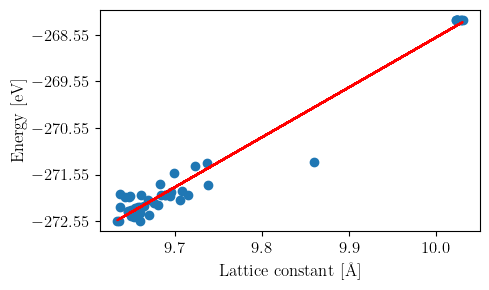

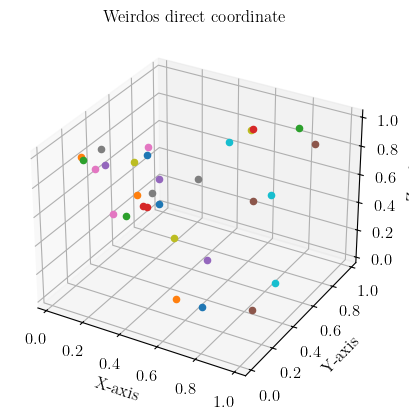

In [53]:
Mapping.AtomIndexing.get_idx_weirdos_el(file_loc_important_cols, "Li", activate_radius)

Mapping.AtomIndexing.idx_correcting_mapped_el(file_loc_important_cols, "Li", activate_radius)
# Mapping.OutputCIF.create_combine_structure(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, var_savefilename = "mapLi")

Mapping.Labelling.get_distance_weirdos_label_el(file_loc_important_cols, coor_ref_structure_48n24, "Li", litype)

Mapping.OutputCIF.create_combine_structure(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, activate_radius, var_savefilename = "mapLi")
Mapping.OutputCIF.rewrite_cif_w_correct_Li_idx(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, amount_Cl, var_savefilename_init = "mapLi", var_savefilename_new = "mapLi_reindexed")
Mapping.OutputCIF.format_spacing_cif(file_loc_important_cols, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed", var_savefilename_new = "mapLi_reindexed")
# # # # Operation.File.delete_files(file_loc_important_cols, direc_restructure_destination, file_name_w_format = "mapLi_reindexed.cif")

Mapping.OutputCIF.rewrite_cif_w_correct_Li_idx_weirdos_appended(file_loc_important_cols, direc_restructure_destination, amount_Li, amount_P, amount_S, amount_Cl, activate_radius,var_savefilename_init = "mapLi", var_savefilename_new = "mapLi_reindexed_weirdos_appended")
Mapping.OutputCIF.format_spacing_cif(file_loc_important_cols, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed_weirdos_appended", var_savefilename_new = "mapLi_reindexed_weirdos_appended")
# # # Operation.File.delete_files(file_loc_important_cols, direc_restructure_destination, file_name_w_format = "mapLi_reindexed_weirdos_appended.cif")

Mapping.OutputCIF.ascending_Li(file_loc_important_cols, direc_restructure_destination, var_filename_init = "mapLi_reindexed_weirdos_appended", var_savefilename_new = "mapLi_reindexed_weirdos_appended_reordered")
# # # Mapping.OutputCIF.format_spacing_cif(file_loc_important_cols, direc_restructure_destination, var_savefilename_init = "mapLi_reindexed_weirdos_appended_reordered", var_savefilename_new = "mapLi_reindexed_weirdos_appended_reordered")

Mapping.AtomIndexing.get_idx_coor_limapped_weirdos_dict(file_loc_important_cols, coor_ref_structure_48n24, activate_radius, litype, el="Li")
Mapping.Labelling.get_label_mapping(file_loc_important_cols, coor_ref_structure_48n24, "Li", activate_radius, litype)

coor_weirdos_Li = Mapping.OutputWeirdos.get_coor_weirdos_array(file_loc_important_cols, activate_radius)
Mapping.OutputWeirdos.create_POSCAR_weirdos(coor_weirdos_Li, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos")

PreProcessingCONTCAR.create_cif_pymatgen(file_loc_important_cols, direc_restructure_destination, file_restructure = "CONTCAR_positive", var_name = "CONTCAR_positive_pymatgen")
PreProcessingCONTCAR.get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, proceed_XDATCAR, var_filename = "CONTCAR")
Plot.StructureAnalysis.energy_vs_latticeconstant(file_loc_important_cols, var_filename = "CONTCAR")
Plot.StructureAnalysis.weirdos_directcoor(file_loc_important_cols, activate_radius)

In [54]:
file_loc_important_cols

,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],subdir_positive_CONTCAR,...,ndim_coor_reducedreference_Li,ndim_coor_weirdos_el,len_coor_weirdos_el,len_coor_reducedreference_Li,len_idx0_weirdos_Li,len_idx_without_weirdos,ndim_flag_coor,atom_mapping_Li_w_dist_label,latticeconstant_structure_dict_CONTCAR,latticeconstant_structure_dict_CONTCAR_flag
0,8.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,0.0,10.0,NaN,0,-271.373566,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.02889, 0.25, 0.75): {'closest24': (0.03173...","{'a': 9.723644545484756, 'b': 9.72364454548475...",True
1,8.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-271.923755,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,2,2,22,2,22,True,"{(0.02889, 0.25, 0.75): {'closest24': (0.01136...","{'a': 9.695540246371898, 'b': 9.69554024637189...",True
2,8.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-271.907989,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.02889, 0.25, 0.75): {'closest24': (0.02597...","{'a': 9.708409024414692, 'b': 9.70840902441469...",True
3,8.0,0.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,12.0,8.0,1,-268.234411,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.97111, 0.25, 0.25): {'closest24': (0.97701...","{'a': 10.02861207843802, 'b': 10.0286120784380...",True
4,7.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,12.0,8.0,11.0,NaN,0,-271.296558,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.02889, 0.75, 0.25): {'closest24': (0.02326...","{'a': 9.737616653695854, 'b': 9.73761665369585...",True
5,7.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,12.0,10.0,NaN,0,-272.228547,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,2,1,23,1,23,True,"{(0.2891699999999999, 0.99125, 0.2891700000000...","{'a': 9.664593742034263, 'b': 9.66459374203426...",True
6,7.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-272.025225,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,2,2,22,2,22,True,"{(0.21082999999999996, 0.99125, 0.21083): {'cl...","{'a': 9.647760703635619, 'b': 9.64776070363561...",True
7,7.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-272.239606,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.06943, 0.79503, 0.0693999999999999): {'clo...","{'a': 9.657557826795715, 'b': 9.65755782679571...",True
8,7.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,7.0,NaN,0,-271.990043,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.25, 0.47111000000000003, 0.75): {'closest2...","{'a': 9.6895115921136, 'b': 9.6895115921136, '...",True
9,7.0,0.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,7.0,8.0,12.0,7.0,1,-268.234004,/home/azka/Documents/01_Masterthesis/Atomic-Po...,...,2,1,0,24,0,24,False,"{(0.97111, 0.25, 0.25): {'closest24': (0.97675...","{'a': 10.03035357182946, 'b': 10.0303535718294...",True


In [55]:
file_loc_important_cols['latticeconstant_structure_dict_CONTCAR']

0     {'a': 9.723644545484756, 'b': 9.72364454548475...
1     {'a': 9.695540246371898, 'b': 9.69554024637189...
2     {'a': 9.708409024414692, 'b': 9.70840902441469...
3     {'a': 10.02861207843802, 'b': 10.0286120784380...
4     {'a': 9.737616653695854, 'b': 9.73761665369585...
5     {'a': 9.664593742034263, 'b': 9.66459374203426...
6     {'a': 9.647760703635619, 'b': 9.64776070363561...
7     {'a': 9.657557826795715, 'b': 9.65755782679571...
8     {'a': 9.6895115921136, 'b': 9.6895115921136, '...
9     {'a': 10.03035357182946, 'b': 10.0303535718294...
10    {'a': 9.660973587152409, 'b': 9.66097358715240...
11    {'a': 9.634255230851988, 'b': 9.63425523085198...
12    {'a': 9.660128761880127, 'b': 9.66012876188012...
13    {'a': 9.651992289724747, 'b': 9.65199228972474...
14    {'a': 9.637617466292715, 'b': 9.63761746629271...
15    {'a': 9.660370499538326, 'b': 9.66037049953832...
16    {'a': 10.023370684699632, 'b': 10.023370684699...
17    {'a': 9.64270734375257, 'b': 9.64270734375

In [56]:
file_loc_important_cols['latticeconstant_structure_dict_CONTCAR'][0]

{'a': 9.723644545484756,
 'b': 9.723644545484756,
 'c': 9.723644545484756,
 'alpha': 90.0,
 'beta': 90.0,
 'gamma': 90.0}

get_dx_dz_init_litype(litype)


create_file_name_allvariables_litype

/home/azka/anaconda3/envs/positionism/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



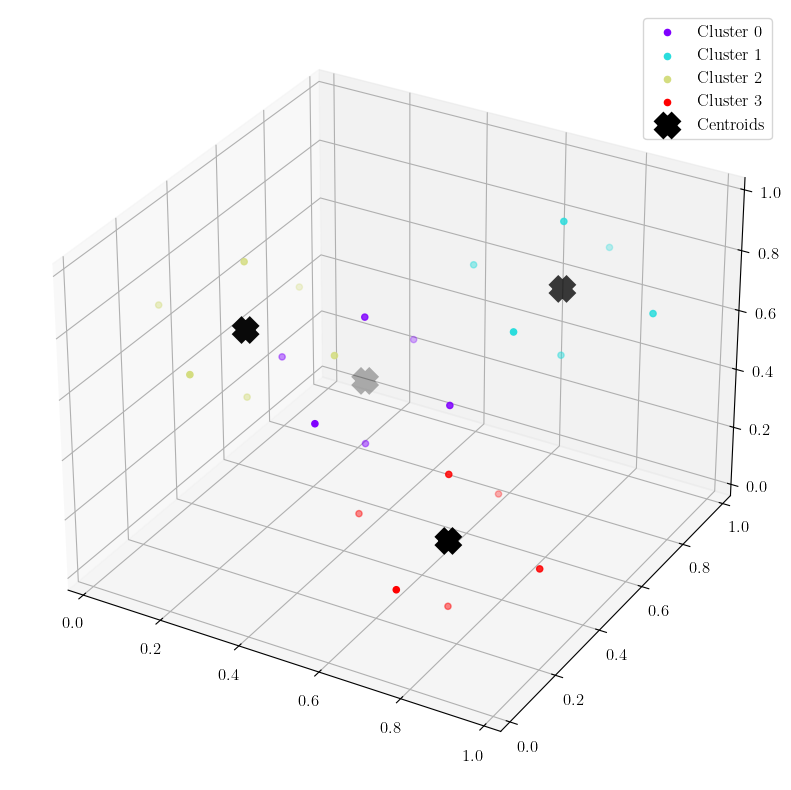

In [57]:
tuple_metainfo = ReadStructure.Metainfo.get_tuple_metainfo(coor_ref_structure_48n24_expanded, litype, el = "Li")
coor_48htype1_metainfo = ReadStructure.Metainfo.get_coor_48htype1_metainfo(coor_ref_structure_48n24_expanded, el = 'Li')

file_loc_important_cols_sorted = file_loc_important_cols.sort_values("toten [eV]", ascending=True).reset_index()

idx_coor_cage_order = {0: np.array([0.97111, 0.25   , 0.25   ]), 3: np.array([0.02889, 0.75   , 0.25   ]),
                       1: np.array([0.02889, 0.25   , 0.75   ]), 2: np.array([0.97111, 0.75   , 0.75   ])}

coor_24g_array = np.array([item['coor'] for sublist in tuple_metainfo.values() for item in sublist if item['type'] == '24g'])
centroids, labels = Operation.KMeans.kmeans_cluster_atoms(coor_24g_array, amount_clusters = 4)
Operation.KMeans.create_POSCAR_atoms_centroids_appended(coor_24g_array, centroids, direc_restructure_destination, lattice_constant, filename = "POSCAR_24g_centroids4")

idx_cage_coor_24g = ReadStructure.Metainfo.get_idx_cage_coor_24g(coor_24g_array, labels, idx_coor_cage_order, amount_clusters = 4)
tuple_cage_metainfo = ReadStructure.Metainfo.get_tuple_cage_metainfo(tuple_metainfo, idx_cage_coor_24g)


category_labels_occupancy = {
    '2': '2',
    '1': '1',
    '0': '0',
    '48htype1': '48htype2',
    'weirdo': 'weirdo'
    # ... add more as needed
}

Movement.Occupancy.get_occupancy(file_loc_important_cols_sorted, coor_ref_structure_48n24_expanded, tuple_cage_metainfo, el = "Li")
df_occupancy = Plot.Movement.Occupancy.plot_occupancy(file_loc_important_cols_sorted, category_labels_occupancy)

In [58]:
file_loc_important_cols_sorted

,index,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],...,len_coor_weirdos_el,len_coor_reducedreference_Li,len_idx0_weirdos_Li,len_idx_without_weirdos,ndim_flag_coor,atom_mapping_Li_w_dist_label,latticeconstant_structure_dict_CONTCAR,latticeconstant_structure_dict_CONTCAR_flag,occupancy,idx_coor24li_tuple_cage_belongin_empty
0,50,0.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,2.0,3.0,1.0,NaN,0,-272.553958,...,0,24,0,24,False,"{(0.33118, 0.02853, 0.66882): {'closest24': (0...","{'a': 9.636711766206595, 'b': 9.63671176620659...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.30709, 0.30709), 'type..."
1,11,6.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,12.0,10.0,NaN,0,-272.549916,...,2,22,2,22,True,"{(0.00875, 0.71083, 0.2891699999999999): {'clo...","{'a': 9.634255230851988, 'b': 9.63425523085198...",True,"{'2': 0, '1': 22, '0': 2, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty..."
2,12,6.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-272.542982,...,0,24,0,24,False,"{(0.30709, 0.028, 0.69291): {'closest24': (0.2...","{'a': 9.660128761880127, 'b': 9.66012876188012...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.19291, 0.19291), 'type..."
3,32,3.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,7.0,NaN,0,-272.460801,...,1,23,1,23,True,"{(0.33118, 0.02853, 0.66882): {'closest24': (0...","{'a': 9.653472670127393, 'b': 9.65347267012739...",True,"{'2': 0, '1': 23, '0': 1, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty..."
4,13,6.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-272.447232,...,0,24,0,24,False,"{(0.30709, 0.028, 0.69291): {'closest24': (0.3...","{'a': 9.651992289724747, 'b': 9.65199228972474...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.99125, 0.28917, 0.28917), 'ty..."
5,22,5.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,7.0,8.0,6.0,NaN,0,-272.443512,...,2,22,2,22,True,"{(0.71083, 0.99125, 0.71083): {'closest24': (0...","{'a': 9.649474541655177, 'b': 9.64947454165517...",True,"{'2': 0, '1': 22, '0': 2, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty..."
6,20,5.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-272.414633,...,0,24,0,24,False,"{(0.21083, 0.71083, 0.49125): {'closest24': (0...","{'a': 9.670669495531701, 'b': 9.67066949553170...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.19291, 0.19291), 'type..."
7,44,1.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,3.0,4.0,2.0,NaN,0,-272.368408,...,0,24,0,24,False,"{(0.00875, 0.71083, 0.2891699999999999): {'clo...","{'a': 9.659303085137076, 'b': 9.65930308513707...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty..."
8,48,0.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,4.0,5.0,3.0,NaN,0,-272.368157,...,0,24,0,24,False,"{(0.30709, 0.028, 0.69291): {'closest24': (0.3...","{'a': 9.660449953488865, 'b': 9.66044995348886...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty..."
9,23,5.0,1.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,6.0,7.0,5.0,NaN,0,-272.362421,...,2,22,2,22,True,"{(0.30709, 0.028, 0.69291): {'closest24': (0.2...","{'a': 9.650535910416489, 'b': 9.65053591041648...",True,"{'2': 0, '1': 22, '0': 2, '48htype1': 0, 'weir...","{0: [{'coor': (0.99125, 0.21083, 0.21083), 'ty..."


In [59]:
Movement.Occupancy.get_occupancy(file_loc_important_cols, coor_ref_structure_48n24_expanded, tuple_cage_metainfo, el = "Li")
df_occupancy = Plot.Movement.Occupancy.plot_occupancy(file_loc_important_cols, category_labels_occupancy)

In [60]:
file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][4]

KeyError: 'idx_coor24li_tuple_cage_belongin_complete_id48htype2'

In [61]:
Movement.TupleCage.get_complete_closest_tuple_cage(file_loc_important_cols, tuple_cage_metainfo, coor_48htype1_metainfo)
# weighing_movement(file_loc_important_cols, litype)
# df_weighted = Movement.TupleCage.get_df_movement(file_loc_important_cols, to_plot = 'weight')
# # Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, Li_idxs="all")
# Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=False, Li_idxs='all')

In [ ]:
# chunk_size = 3
# total_items = amount_Li  # Adjust this if your total number of items changes

# # Loop through the range in steps of chunk_size
# for start_idx in range(0, total_items, chunk_size):
#     end_idx = start_idx + chunk_size
#     Li_idxs_range = range(start_idx, end_idx)
    
#     # Call your function with the current range of Li_idxs
#     Plot.Movement.Distance.plot_distance(df_weighted, max_mapping_radius, activate_shifting_x = False, activate_diameter_line = False, Li_idxs = Li_idxs_range)

idx_coor24li_tuple_cage_belongin_complete_id48htype2

In [62]:
category_labels = {
    '48htype1': '48htype2',
    '48htype2': '48htype1',
    '48htype3': '48htype3',
    '48htype4': '48htype4',
    '24g': '24g',
    'weirdo': 'weirdo'
    # ... add more as needed
}

if proceed_NEB == "True":
    df_type = Movement.TupleCage.get_df_movement(file_loc_important_cols, to_plot = 'type', activate_closest_tuple = False)
    df_idx_tuple = Movement.TupleCage.get_df_movement(file_loc_important_cols, to_plot = 'idx_tuple', activate_closest_tuple = False)
    df_idx_cage = Movement.TupleCage.get_df_movement(file_loc_important_cols, to_plot = 'idx_cage', activate_closest_tuple = False)

    # category_labels_activate_s_i = {
    #     '48htype1': '48htype2',
    #     '48htype2': '48htype1',
    #     '48htype3': '48htype3',
    #     '48htype4': '48htype4',
    #     '24g': '24g',
    #     'weirdo': 'weirdo'
    #     # ... add more as needed
    # }

    # # Plot.Movement.Distance.plot_distance(df_idx_cage, max_mapping_radius, Li_idxs="all")
    Plot.Movement.TupleCage.plot_cage_tuple_label(df_idx_cage, df_type, df_idx_tuple, max_mapping_radius, litype, category_labels, activate_diameter_line=False, activate_relabel_s_i = True, Li_idxs="all")

In [63]:
if proceed_NEB == "True":
    chunk_size = 3
    total_items = amount_Li  # Adjust this if your total number of items changes

    # Loop through the range in steps of chunk_size
    for start_idx in range(0, total_items, chunk_size):
        end_idx = start_idx + chunk_size
        Li_idxs_range = range(start_idx, end_idx)
        
        # Call your function with the current range of Li_idxs
        Plot.Movement.TupleCage.plot_cage_tuple_label(df_idx_cage, df_type, df_idx_tuple, max_mapping_radius, litype, category_labels, activate_diameter_line=False, activate_relabel_s_i=True, Li_idxs=Li_idxs_range)

In [64]:
if proceed_NEB == "True":
    df_movement = Movement.TupleCage.get_df_movement_category(file_loc_important_cols, activate_closest_tuple=False)
    Plot.Movement.Distance.plot_distance(df_movement, max_mapping_radius, activate_shifting_x = True, activate_diameter_line = False, Li_idxs = 'all')

In [65]:
if proceed_NEB == "True":
    chunk_size = 3
    total_items = amount_Li  # Adjust this if your total number of items changes

    # Loop through the range in steps of chunk_size
    for start_idx in range(0, total_items, chunk_size):
        end_idx = start_idx + chunk_size
        Li_idxs_range = range(start_idx, end_idx)
        
        # Call your function with the current range of Li_idxs
        Plot.Movement.Distance.plot_distance(df_movement, max_mapping_radius, activate_shifting_x = True, activate_diameter_line = False, Li_idxs = Li_idxs_range)

In [66]:
# # Mapping.Labelling.get_amount_type(file_loc_important_cols_sorted, litype, el = "Li")

el = "Li"
style = "bar"

# # df = Plot.Mapping.Labelling.plot_amount_type(file_loc_important_cols_sorted, litype, el, style, category_labels)

In [67]:
Mapping.Labelling.get_amount_type(file_loc_important_cols, litype, el = "Li")
df_amount_type = Plot.Mapping.Labelling.plot_amount_type(file_loc_important_cols, litype, el, style, category_labels)

In [68]:
Mapping.Labelling.get_amount_type(file_loc_important_cols_sorted, litype, el = "Li")
df_amount_type_sorted = Plot.Mapping.Labelling.plot_amount_type(file_loc_important_cols_sorted, litype, el, style, category_labels)

weirdo exists at file nr.:
16 =
17 =

48htype2 exists at:
17 =
20 =

In [69]:
file_loc_important_cols_sorted.head()

,index,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],...,len_coor_reducedreference_Li,len_idx0_weirdos_Li,len_idx_without_weirdos,ndim_flag_coor,atom_mapping_Li_w_dist_label,latticeconstant_structure_dict_CONTCAR,latticeconstant_structure_dict_CONTCAR_flag,occupancy,idx_coor24li_tuple_cage_belongin_empty,amount_type_Li
0,50,0.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,2.0,3.0,1.0,NaN,0,-272.553958,...,24,0,24,False,"{(0.33118, 0.02853, 0.66882): {'closest24': (0...","{'a': 9.636711766206595, 'b': 9.63671176620659...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.30709, 0.30709), 'type...","{'48htype1': 0, '48htype2': 8, '48htype3': 8, ..."
1,11,6.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,12.0,10.0,NaN,0,-272.549916,...,22,2,22,True,"{(0.00875, 0.71083, 0.2891699999999999): {'clo...","{'a': 9.634255230851988, 'b': 9.63425523085198...",True,"{'2': 0, '1': 22, '0': 2, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty...","{'48htype1': 0, '48htype2': 8, '48htype3': 8, ..."
2,12,6.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,10.0,11.0,9.0,NaN,0,-272.542982,...,24,0,24,False,"{(0.30709, 0.028, 0.69291): {'closest24': (0.2...","{'a': 9.660128761880127, 'b': 9.66012876188012...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.19291, 0.19291), 'type...","{'48htype1': 0, '48htype2': 10, '48htype3': 8,..."
3,32,3.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,8.0,9.0,7.0,NaN,0,-272.460801,...,23,1,23,True,"{(0.33118, 0.02853, 0.66882): {'closest24': (0...","{'a': 9.653472670127393, 'b': 9.65347267012739...",True,"{'2': 0, '1': 23, '0': 1, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty...","{'48htype1': 0, '48htype2': 5, '48htype3': 9, ..."
4,13,6.0,3.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-272.447232,...,24,0,24,False,"{(0.30709, 0.028, 0.69291): {'closest24': (0.3...","{'a': 9.651992289724747, 'b': 9.65199228972474...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.99125, 0.28917, 0.28917), 'ty...","{'48htype1': 0, '48htype2': 7, '48htype3': 9, ..."


In [70]:
if proceed_NEB == "True":
    df = Movement.TupleCage.get_and_plot_df_movement_category_counted(df_movement)
    print(df.sum())

In [71]:
test = pd.concat([file_loc_important_cols_sorted[6:7], file_loc_important_cols_sorted[0:2]], ignore_index=False)

In [72]:
test

,index,geometry,path,subdir_new_system,g+p,g+p+1,g+p-1,perfect_system,p_s_mask,toten [eV],...,len_coor_reducedreference_Li,len_idx0_weirdos_Li,len_idx_without_weirdos,ndim_flag_coor,atom_mapping_Li_w_dist_label,latticeconstant_structure_dict_CONTCAR,latticeconstant_structure_dict_CONTCAR_flag,occupancy,idx_coor24li_tuple_cage_belongin_empty,amount_type_Li
6,20,5.0,4.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,9.0,10.0,8.0,NaN,0,-272.414633,...,24,0,24,False,"{(0.21083, 0.71083, 0.49125): {'closest24': (0...","{'a': 9.670669495531701, 'b': 9.67066949553170...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.19291, 0.19291), 'type...","{'48htype1': 0, '48htype2': 10, '48htype3': 7,..."
0,50,0.0,2.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,2.0,3.0,1.0,NaN,0,-272.553958,...,24,0,24,False,"{(0.33118, 0.02853, 0.66882): {'closest24': (0...","{'a': 9.636711766206595, 'b': 9.63671176620659...",True,"{'2': 0, '1': 24, '0': 0, '48htype1': 0, 'weir...","{0: [{'coor': (0.972, 0.30709, 0.30709), 'type...","{'48htype1': 0, '48htype2': 8, '48htype3': 8, ..."
1,11,6.0,5.0,/home/azka/Documents/01_Masterthesis/Atomic-Po...,11.0,12.0,10.0,NaN,0,-272.549916,...,22,2,22,True,"{(0.00875, 0.71083, 0.2891699999999999): {'clo...","{'a': 9.634255230851988, 'b': 9.63425523085198...",True,"{'2': 0, '1': 22, '0': 2, '48htype1': 0, 'weir...","{0: [{'coor': (0.97147, 0.33118, 0.33118), 'ty...","{'48htype1': 0, '48htype2': 8, '48htype3': 8, ..."


# Intra triad

In [73]:
var_filename = "CONTCAR_positive"

In [74]:
# # idx_ref = 0
# # idx_file_group = [0, 16]
# # mean_ref = False
# # df_distance, dataframe_group = Movement.Distance.get_distance_litoli(file_loc_important_cols_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, Li_idxs="all")

# # df_distance_average_rms = df_distance.copy()
# # column_averages = df_distance.mean()
# # df = df.append(column_averages, ignore_index=True)

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intratriad_litype{litype}_{var_filename}.xlsx', index=True)

# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=True, Li_idxs='all')

In [75]:
# df_distance.iloc[:, :12]

In [76]:
# df_distance.iloc[:, 12:24]

In [77]:
file_loc_important_cols_sorted['geometry'][2]

6.0

coor_Li_ref: [array([0.95835192, 0.31685874, 0.33103917]), array([0.99430774, 0.70141252, 0.69614921]), array([0.02858495, 0.27573254, 0.68386619]), array([0.07317737, 0.78755527, 0.07908696]), array([0.18178152, 0.19006794, 0.97419491]), array([0.34472333, 0.64878575, 0.04763612]), array([0.79589717, 0.21510678, 0.02025111]), array([0.69483125, 0.67827248, 0.96747641]), array([0.19957707, 0.98852095, 0.22489566]), array([0.32196063, 0.02614832, 0.73040604]), array([0.83198746, 0.96166074, 0.82571183]), array([0.82470757, 0.02052615, 0.21474765]), array([0.27490918, 0.80022583, 0.48200606]), array([0.32964366, 0.21528613, 0.52567716]), array([0.72751201, 0.8224285 , 0.52388656]), array([0.66606279, 0.17108496, 0.46734986]), array([0.213564  , 0.4794397 , 0.70118373]), array([0.16863312, 0.54818007, 0.32165261]), array([0.71427014, 0.48185846, 0.20961033]), array([0.789857  , 0.51568295, 0.66980573]), array([0.47820257, 0.32562985, 0.83345355]), array([0.4863265 , 0.81195002, 0.29922602

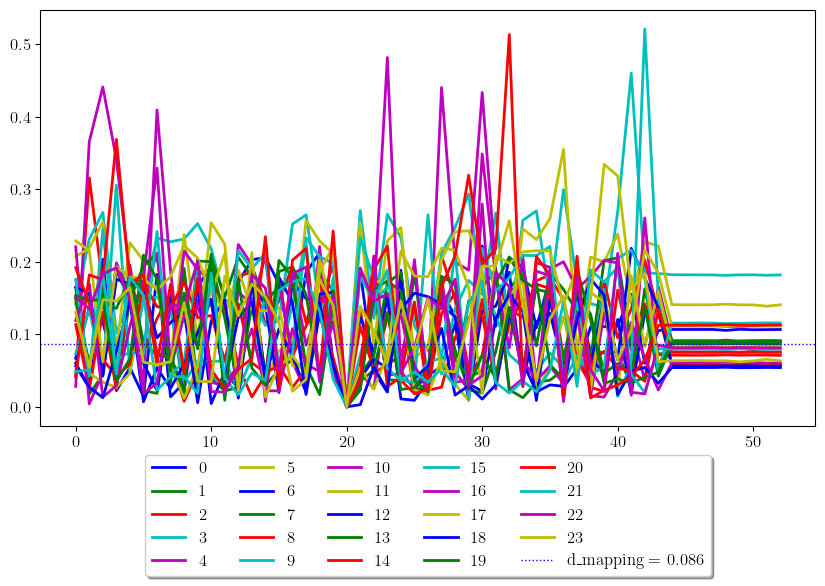

In [78]:
idx_ref = 20
idx_file_group = [0, 53]
mean_ref = False

df_distance, dataframe_group = Movement.Distance.get_distance_litoli(file_loc_important_cols_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=True, Li_idxs="all")

# # df_distance_average_rms = df_distance.copy()
# # column_averages = df_distance.mean()
# # df = df.append(column_averages, ignore_index=True)

df_distance.transpose().to_excel(f'06_distance_LitoLi_intercage_litype{litype}_{var_filename}_{idx_ref}.xlsx', index=True)

In [79]:
df_distance

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.056341,0.164118,0.042970,0.141593,0.028169,0.207524,0.066915,0.150745,0.113397,0.073543,...,0.191992,0.175631,0.119093,0.228894,0.060040,0.153717,0.041539,0.048598,0.151294,0.130317
1,0.026315,0.017824,0.315886,0.231258,0.365774,0.218636,0.137140,0.058399,0.023746,0.134722,...,0.142556,0.042657,0.169850,0.215555,0.027035,0.146580,0.181982,0.051309,0.135254,0.054519
2,0.203442,0.043882,0.167654,0.268108,0.441160,0.255361,0.117556,0.161283,0.130791,0.044586,...,0.065047,0.244820,0.013321,0.062346,0.012655,0.148199,0.175442,0.183064,0.183376,0.147921
3,0.022389,0.187724,0.026123,0.102007,0.341845,0.079135,0.042353,0.027237,0.023984,0.305675,...,0.043016,0.064437,0.029352,0.193132,0.076227,0.035173,0.368978,0.045200,0.191780,0.146016
4,0.054093,0.146991,0.195546,0.148727,0.181158,0.226328,0.178613,0.147977,0.169437,0.046709,...,0.058524,0.076009,0.110829,0.179564,0.146550,0.066281,0.170241,0.179192,0.148818,0.164444
5,0.014561,0.022491,0.076243,0.153583,0.027185,0.201646,0.060037,0.194516,0.179096,0.147316,...,0.171324,0.072618,0.179264,0.176617,0.007055,0.209345,0.182343,0.153692,0.018538,0.061487
6,0.182623,0.018515,0.121699,0.233080,0.409471,0.051789,0.022674,0.211222,0.074450,0.151488,...,0.138046,0.241930,0.329267,0.161502,0.053736,0.176069,0.059326,0.023296,0.032879,0.058221
7,0.013828,0.140918,0.156107,0.227666,0.187826,0.065079,0.155334,0.032793,0.066322,0.131857,...,0.136654,0.043844,0.052773,0.179614,0.025586,0.049513,0.168982,0.041299,0.141222,0.062229
8,0.033509,0.019267,0.051791,0.231626,0.022141,0.237789,0.026559,0.190990,0.007632,0.033293,...,0.171936,0.063384,0.126134,0.222368,0.059028,0.156892,0.045720,0.041815,0.137947,0.143587
9,0.165585,0.204411,0.172960,0.252744,0.146887,0.090149,0.170180,0.029229,0.048600,0.063350,...,0.123123,0.188758,0.137353,0.205089,0.102638,0.079907,0.176682,0.018704,0.201189,0.035421


In [80]:
idx_ref = 0
idx_file_group = [0, 16]
mean_ref = True

# # df_distance, dataframe_group = Movement.Distance.get_distance_litoli(file_loc_important_cols_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=True, Li_idxs="all")

# # df_distance_average_rms = df_distance.copy()
# # column_averages = df_distance.mean()
# # df = df.append(column_averages, ignore_index=True)

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intratriad_litype{litype}_{var_filename}_meanref.xlsx', index=True)

In [81]:
# df_distance

In [82]:
# for i in range(amount_Li):
#     Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_diameter_line=False, Li_idxs=[i])

In [83]:
dataframe = file_loc_important_cols
idx_ref = 0
destination_directory = direc_restructure_destination
coor_Li_ref = []

if 'CONTCAR' in var_filename:
    file_ref = f"{int(dataframe['geometry'][idx_ref])}_{int(dataframe['path'][idx_ref])}_{var_filename}"
else:
    file_ref = f"{int(dataframe['geometry'][idx_ref])}_{int(dataframe['path'][idx_ref])}_{var_filename}.cif"
file_path_ref = os.path.join(destination_directory, file_ref)

structure_ref = Structure.from_file(file_path_ref)

for idx, coor in enumerate(structure_ref):
    if coor.species_string == "Li":
        coor_Li_ref.append(coor.frac_coords)

In [84]:
coor_Li_ref

[array([0.97907504, 0.21590456, 0.21506876]),
 array([0.97907504, 0.71506876, 0.71590456]),
 array([0.03173069, 0.26100412, 0.76100412]),
 array([0.27969664, 0.411814  , 0.911814  ]),
 array([0.2158551 , 0.09387325, 0.93490032]),
 array([0.24099064, 0.74583386, 0.03397036]),
 array([0.78787699, 0.20089999, 0.02639275]),
 array([0.74986626, 0.73809461, 0.99965056]),
 array([0.07748468, 0.93133711, 0.22102444]),
 array([0.34659232, 0.99705648, 0.68493332]),
 array([0.82459666, 0.97331628, 0.8177076 ]),
 array([0.6856612 , 0.05011573, 0.32621871]),
 array([0.07748468, 0.72102444, 0.43133711]),
 array([0.34659232, 0.18493332, 0.49705648]),
 array([0.6856612 , 0.82621871, 0.55011573]),
 array([0.82459666, 0.3177076 , 0.47331628]),
 array([0.2158551 , 0.43490032, 0.59387325]),
 array([0.24099064, 0.53397036, 0.24583386]),
 array([0.74986626, 0.49965056, 0.23809461]),
 array([0.78787699, 0.52639275, 0.70089999]),
 array([0.49818614, 0.30400294, 0.80400294]),
 array([0.45092654, 0.82405569, 0.

In [85]:
coor_Li_ref_mean = np.mean(coor_Li_ref, axis=0)

In [86]:
coor_Li_ref_mean

array([0.50493386, 0.52087209, 0.52087209])

coor_Li_ref: [array([0.97907504, 0.21590456, 0.21506876]), array([0.97907504, 0.71506876, 0.71590456]), array([0.03173069, 0.26100412, 0.76100412]), array([0.27969664, 0.411814  , 0.911814  ]), array([0.2158551 , 0.09387325, 0.93490032]), array([0.24099064, 0.74583386, 0.03397036]), array([0.78787699, 0.20089999, 0.02639275]), array([0.74986626, 0.73809461, 0.99965056]), array([0.07748468, 0.93133711, 0.22102444]), array([0.34659232, 0.99705648, 0.68493332]), array([0.82459666, 0.97331628, 0.8177076 ]), array([0.6856612 , 0.05011573, 0.32621871]), array([0.07748468, 0.72102444, 0.43133711]), array([0.34659232, 0.18493332, 0.49705648]), array([0.6856612 , 0.82621871, 0.55011573]), array([0.82459666, 0.3177076 , 0.47331628]), array([0.2158551 , 0.43490032, 0.59387325]), array([0.24099064, 0.53397036, 0.24583386]), array([0.74986626, 0.49965056, 0.23809461]), array([0.78787699, 0.52639275, 0.70089999]), array([0.49818614, 0.30400294, 0.80400294]), array([0.45092654, 0.82405569, 0.32405569

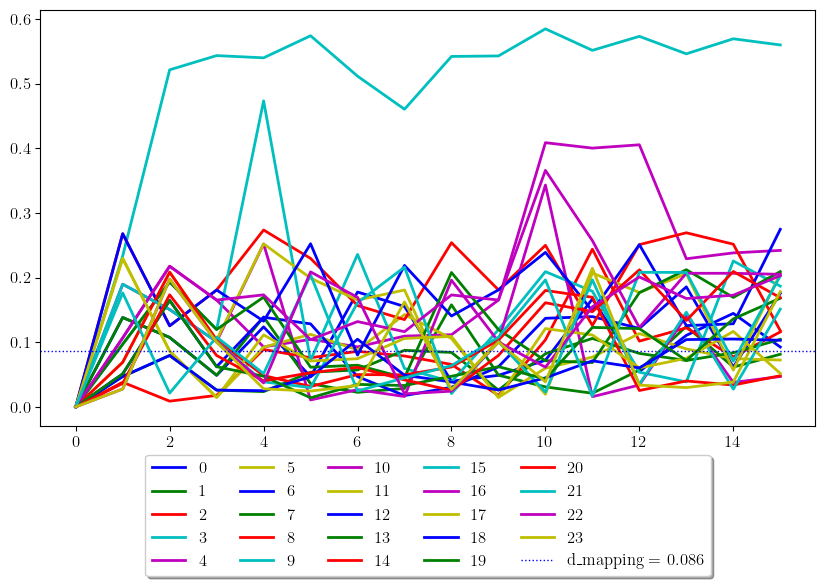

In [87]:
idx_ref = 0
idx_file_group = [0, 16]
mean_ref = False
df_distance, dataframe_group = Movement.Distance.get_distance_litoli(file_loc_important_cols, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line=True, Li_idxs="all")


In [88]:
df_distance.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.138127,0.138127,0.038044,0.233394,0.106551,0.229600,0.050937,0.046895,0.267744,0.096781,0.189559,0.068870
2,0.107344,0.107344,0.008772,0.521160,0.217437,0.086154,0.164556,0.079441,0.125291,0.193000,0.150441,0.208180
3,0.048781,0.048781,0.017709,0.543163,0.165112,0.014572,0.062029,0.025827,0.180697,0.119554,0.100838,0.103340
4,0.123686,0.138905,0.088713,0.539713,0.092694,0.092319,0.138554,0.023552,0.273432,0.473172,0.251776,0.252082
5,0.046781,0.035832,0.075931,0.573856,0.104313,0.112091,0.128308,0.053457,0.229516,0.071853,0.010663,0.198965
6,0.177547,0.022460,0.085853,0.511377,0.092750,0.088081,0.046758,0.057095,0.156653,0.235686,0.026585,0.165104
7,0.155146,0.028439,0.078594,0.460230,0.109355,0.142708,0.017432,0.087423,0.134876,0.059337,0.015954,0.180652
8,0.039530,0.157750,0.065602,0.541847,0.111511,0.105700,0.030279,0.084122,0.253867,0.038786,0.195835,0.022547
9,0.048781,0.048968,0.017661,0.542641,0.165109,0.014618,0.061976,0.025871,0.180841,0.119287,0.100778,0.103483


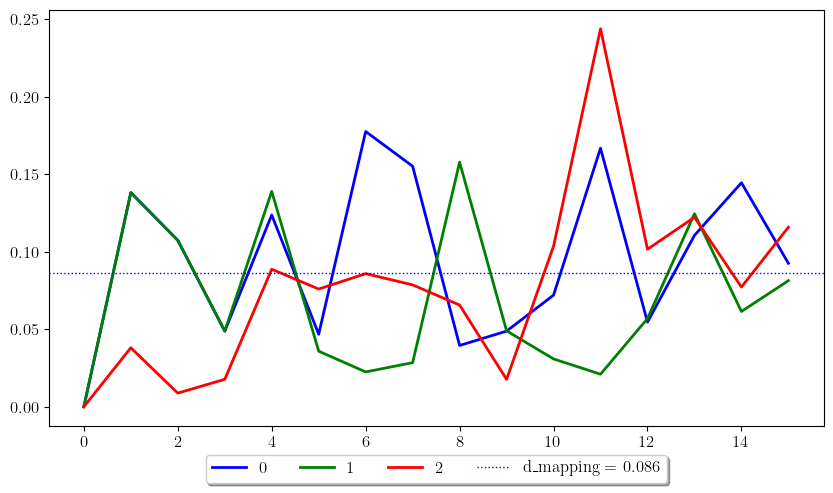

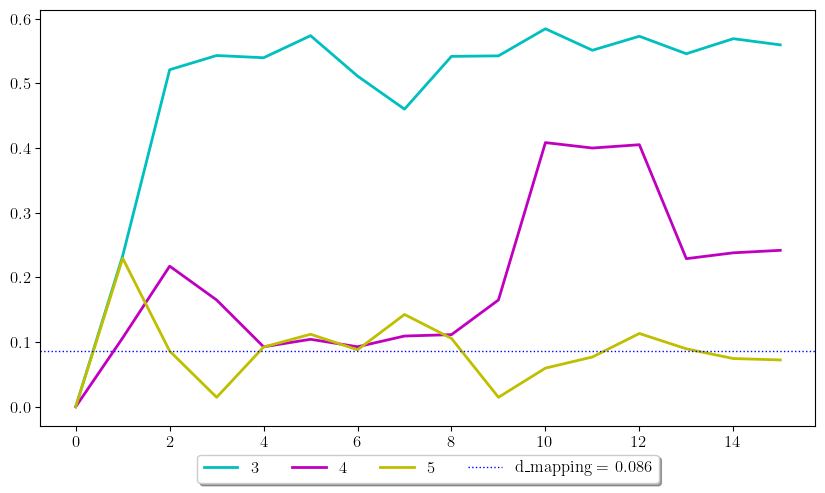

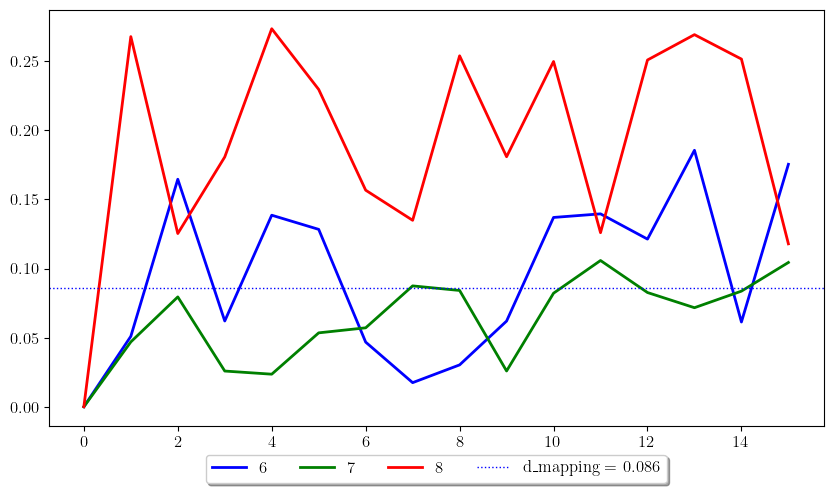

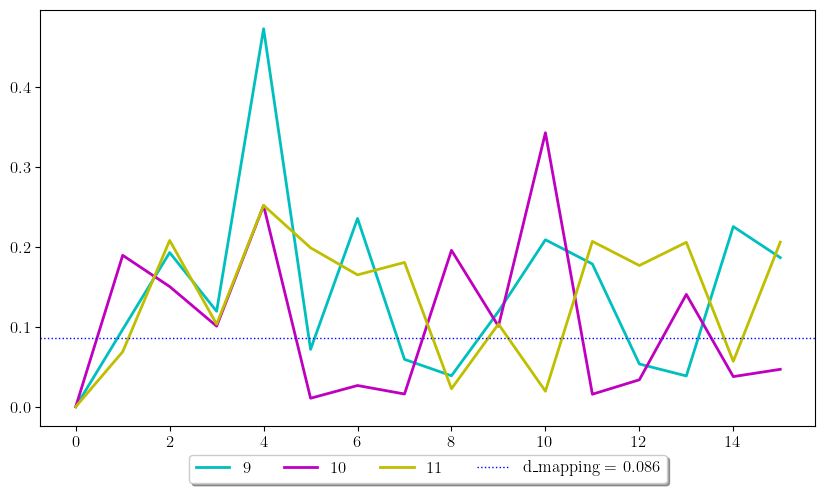

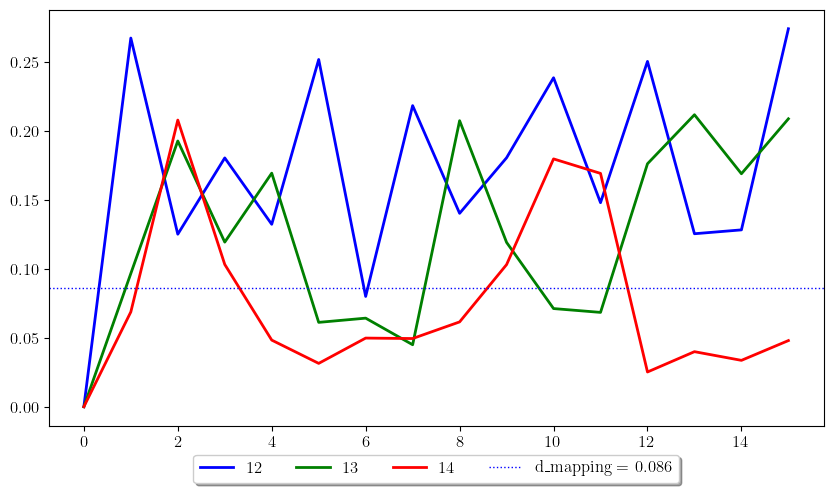

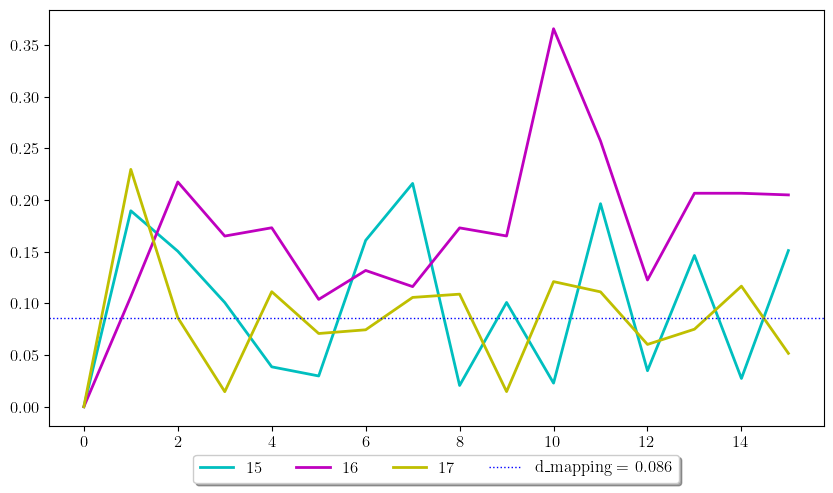

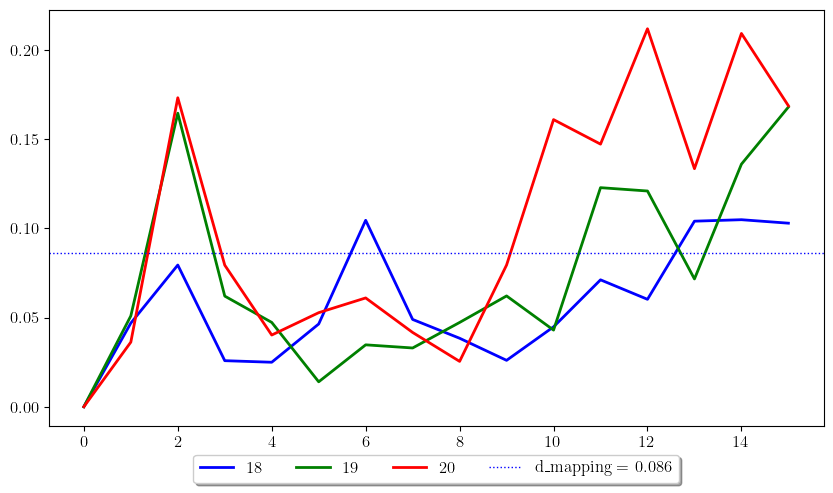

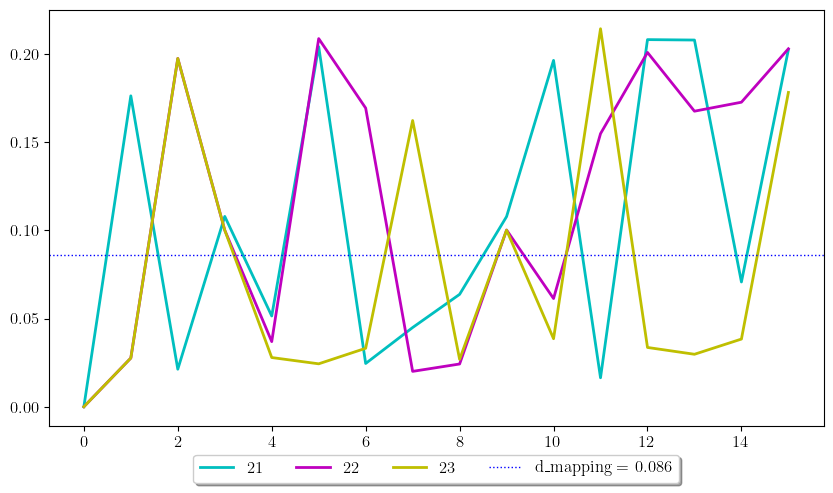

In [89]:
chunk_size = 3
total_items = amount_Li  # Adjust this if your total number of items changes

# Loop through the range in steps of chunk_size
for start_idx in range(0, total_items, chunk_size):
    end_idx = start_idx + chunk_size
    Li_idxs_range = range(start_idx, end_idx)
    
    # Call your function with the current range of Li_idxs
    Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x = False, activate_diameter_line = True, Li_idxs = Li_idxs_range)

# Intra cage

In [90]:
# # idx_ref = 3 # 20
# # idx_file_group = [0, 16]
# # mean_ref = False
# # df_distance, dataframe_group = get_distance_litoli(file_loc_important_cols_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x=False, activate_diameter_line=False, Li_idxs="all")

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intracage_litype{litype}_{var_filename}.xlsx', index=True)

In [91]:
df_distance

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.138127,0.138127,0.038044,0.233394,0.106551,0.229600,0.050937,0.046895,0.267744,0.096781,...,0.068870,0.189559,0.106551,0.229600,0.046895,0.050937,0.036232,0.176210,0.027590,0.027590
2,0.107344,0.107344,0.008772,0.521160,0.217437,0.086154,0.164556,0.079441,0.125291,0.193000,...,0.208180,0.150441,0.217437,0.086154,0.079441,0.164556,0.173218,0.021279,0.197422,0.197422
3,0.048781,0.048781,0.017709,0.543163,0.165112,0.014572,0.062029,0.025827,0.180697,0.119554,...,0.103340,0.100838,0.165112,0.014572,0.025827,0.062029,0.079374,0.107876,0.100055,0.100055
4,0.123686,0.138905,0.088713,0.539713,0.092694,0.092319,0.138554,0.023552,0.273432,0.473172,...,0.048401,0.038597,0.173132,0.111276,0.024949,0.047284,0.040203,0.051444,0.036922,0.027891
5,0.046781,0.035832,0.075931,0.573856,0.104313,0.112091,0.128308,0.053457,0.229516,0.071853,...,0.031494,0.029778,0.103847,0.070840,0.046396,0.013983,0.052736,0.204080,0.208661,0.024331
6,0.177547,0.022460,0.085853,0.511377,0.092750,0.088081,0.046758,0.057095,0.156653,0.235686,...,0.049866,0.160931,0.131836,0.074436,0.104525,0.034710,0.060997,0.024524,0.169268,0.033141
7,0.155146,0.028439,0.078594,0.460230,0.109355,0.142708,0.017432,0.087423,0.134876,0.059337,...,0.049536,0.216025,0.116209,0.105764,0.048939,0.032947,0.041646,0.044902,0.020049,0.162231
8,0.039530,0.157750,0.065602,0.541847,0.111511,0.105700,0.030279,0.084122,0.253867,0.038786,...,0.061613,0.020565,0.173022,0.108901,0.038402,0.047253,0.025434,0.063701,0.024233,0.026866
9,0.048781,0.048968,0.017661,0.542641,0.165109,0.014618,0.061976,0.025871,0.180841,0.119287,...,0.103231,0.100889,0.165183,0.014661,0.026017,0.062120,0.079457,0.107784,0.100182,0.100092


In [92]:
# # idx_ref = 3 # 20
# # idx_file_group = [0, 16]
# # mean_ref = True
# # df_distance, dataframe_group = get_distance_litoli(file_loc_important_cols_sorted, max_mapping_radius, direc_restructure_destination, idx_file_group, idx_ref, mean_ref, var_filename)
# # Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_shifting_x=False, activate_diameter_line=False, Li_idxs="all")

# # df_distance.transpose().to_excel(f'06_distance_LitoLi_intracage_litype{litype}_{var_filename}_meanref.xlsx', index=True)

In [93]:
# for i in range(amount_Li):
#    Plot.Movement.Distance.plot_distance(df_distance, max_mapping_radius, activate_diameter_line=False, Li_idxs=[i])

In [94]:
file_loc_important_cols.columns

Index(['geometry', 'path', 'subdir_new_system', 'g+p', 'g+p+1', 'g+p-1',
       'perfect_system', 'p_s_mask', 'toten [eV]', 'subdir_positive_CONTCAR',
       'coor_structure_init_dict', 'flag_Li', 'coor_weirdos_Li',
       'sum_weirdos_Li', 'duplicate_closest24_w_data_Li',
       'coor_reducedreference_Li_closestduplicate',
       'sum_mapped_Li_closestduplicate', 'sum_sanitycheck_Li_closestduplicate',
       'atom_mapping_Li_closestduplicate',
       'atom_mapping_Li_w_dist_closestduplicate', 'idx0_weirdos_Li',
       '#weirdos_Li', 'idx_coor_weirdos_Li', 'idx_correcting_Li',
       'coor_reducedreference_sorted_Li', '#closest_24g_Li',
       '#closest_48htype1_Li', '#closest_48htype2_Li', '#closest_48htype3_Li',
       '#closest_48htype4_Li', 'top3_sorted_idxweirdo_dist_label_Li',
       'top3_sorted_idxweirdo_dist_Li', 'top3_sorted_idxweirdo_label_Li',
       'top1_sorted_idxweirdo_dist_label_Li', 'top1_sorted_idxweirdo_dist_Li',
       'top1_sorted_idxweirdo_label_Li', 'top1_sorted

In [95]:
file_loc_important_cols['idx_coor_limapped_weirdos_dict'][1]

{0: {'coor': (0.972, 0.30709, 0.30709), 'label': '48htype2'},
 1: {'coor': (0.972, 0.80709, 0.80709), 'label': '48htype2'},
 2: {'coor': (0.02889, 0.25, 0.75), 'label': '24g'},
 3: {'coor': (0.29503, 0.5694, 0.06943), 'label': '48htype1'},
 4: {'coor': (0.19290999999999991, 0.19291000000000003, 0.972),
  'label': '48htype2'},
 6: {'coor': (0.83118, 0.16882000000000003, 0.02853), 'label': '48htype3'},
 7: {'coor': (0.71083, 0.71083, 0.99125), 'label': '48htype4'},
 8: {'coor': (0.30709, 0.972, 0.30709), 'label': '48htype2'},
 9: {'coor': (0.25, 0.02889, 0.75), 'label': '24g'},
 10: {'coor': (0.69291, 0.972, 0.69291), 'label': '48htype2'},
 11: {'coor': (0.71083, 0.00875, 0.28917000000000004), 'label': '48htype4'},
 12: {'coor': (0.30709, 0.80709, 0.472), 'label': '48htype2'},
 13: {'coor': (0.25, 0.25, 0.52889), 'label': '24g'},
 14: {'coor': (0.71083, 0.78917, 0.50875), 'label': '48htype4'},
 15: {'coor': (0.69291, 0.19291000000000003, 0.472), 'label': '48htype2'},
 16: {'coor': (0.192

In [96]:
file_loc_important_cols['idx_coor_weirdos_Li'][4]

{}

In [97]:
file_loc_important_cols['coor_reduced120_sorted_Li'][4]

KeyError: 'coor_reduced120_sorted_Li'

In [98]:
len(file_loc_important_cols['coor_reduced120_sorted_Li'][4])

KeyError: 'coor_reduced120_sorted_Li'

In [99]:
file_loc_important_cols['atom_mapping_Li_w_dist_closestduplicate'][4]

{(0.02889,
  0.75,
  0.25): {'closest24': (0.0232656448425935,
   0.7435006893845341,
   0.2516923363334376), 'dist': 0.008760046328554798},
 (0.75,
  0.75,
  0.97111): {'closest24': (0.7483512647165577,
   0.7435006893845341,
   0.9767779562074018), 'dist': 0.00877981173375605},
 (0.25,
  0.47111000000000003,
  0.75): {'closest24': (0.2368942211037116,
   0.4645224767742665,
   0.7631493799462767), 'dist': 0.01969931713789901},
 (0.75,
  0.47111000000000003,
  0.25): {'closest24': (0.7477821216237366,
   0.4792201409996487,
   0.2522614794262871), 'dist': 0.008706759484538399},
 (0.5694,
  0.93057,
  0.70497): {'closest24': (0.5936001553865534,
   0.9438310081408293,
   0.72198741546301), 'dist': 0.032420584305116476},
 (0.29503,
  0.93057,
  0.4306): {'closest24': (0.2780561855870067,
   0.9438310081408293,
   0.4064434456634491), 'dist': 0.0323651638347872},
 (0.99125,
  0.28917000000000004,
  0.2891699999999999): {'closest24': (0.9913494198331985,
   0.3198905233108648,
   0.280906

In [100]:
len(file_loc_important_cols['atom_mapping_Li_w_dist_closestduplicate'][4])

24

In [101]:
file_loc_important_cols['atom_mapping_Li_w_dist_label'][4]

{(0.02889,
  0.75,
  0.25): {'closest24': (0.0232656448425935,
   0.7435006893845341,
   0.2516923363334376), 'dist': 0.008760046328554798, 'label': '24g'},
 (0.75,
  0.75,
  0.97111): {'closest24': (0.7483512647165577,
   0.7435006893845341,
   0.9767779562074018), 'dist': 0.00877981173375605, 'label': '24g'},
 (0.25,
  0.47111000000000003,
  0.75): {'closest24': (0.2368942211037116,
   0.4645224767742665,
   0.7631493799462767), 'dist': 0.01969931713789901, 'label': '24g'},
 (0.75,
  0.47111000000000003,
  0.25): {'closest24': (0.7477821216237366,
   0.4792201409996487,
   0.2522614794262871), 'dist': 0.008706759484538399, 'label': '24g'},
 (0.5694,
  0.93057,
  0.70497): {'closest24': (0.5936001553865534,
   0.9438310081408293,
   0.72198741546301), 'dist': 0.032420584305116476, 'label': '48htype1'},
 (0.29503,
  0.93057,
  0.4306): {'closest24': (0.2780561855870067,
   0.9438310081408293,
   0.4064434456634491), 'dist': 0.0323651638347872, 'label': '48htype1'},
 (0.99125,
  0.28917

In [102]:
file_loc_important_cols['idx_coor_limapped_weirdos_dict'][4]

{0: {'coor': (0.99125, 0.28917000000000004, 0.2891699999999999),
  'label': '48htype4'},
 1: {'coor': (0.972, 0.80709, 0.80709), 'label': '48htype2'},
 2: {'coor': (0.028, 0.19290999999999991, 0.80709), 'label': '48htype2'},
 3: {'coor': (0.02889, 0.75, 0.25), 'label': '24g'},
 4: {'coor': (0.19290999999999991, 0.19291000000000003, 0.972),
  'label': '48htype2'},
 5: {'coor': (0.19290999999999991, 0.80709, 0.028), 'label': '48htype2'},
 6: {'coor': (0.71083, 0.2891699999999999, 0.00875), 'label': '48htype4'},
 7: {'coor': (0.75, 0.75, 0.97111), 'label': '24g'},
 8: {'coor': (0.29503, 0.93057, 0.4306), 'label': '48htype1'},
 9: {'coor': (0.66882, 0.02853, 0.33118000000000003), 'label': '48htype3'},
 10: {'coor': (0.5694, 0.93057, 0.70497), 'label': '48htype1'},
 11: {'coor': (0.83118, 0.02853, 0.16881999999999997), 'label': '48htype3'},
 12: {'coor': (0.16881999999999997, 0.66882, 0.47147), 'label': '48htype3'},
 13: {'coor': (0.21083, 0.2891699999999999, 0.50875), 'label': '48htype4'},

In [103]:
file_loc_important_cols['idx_coor_limapped_weirdos_dict_init'][4]

{0: array([0.99125, 0.28917, 0.28917]),
 1: array([0.972  , 0.80709, 0.80709]),
 2: array([0.028  , 0.19291, 0.80709]),
 3: array([0.02889, 0.75   , 0.25   ]),
 4: array([0.19291, 0.19291, 0.972  ]),
 5: array([0.19291, 0.80709, 0.028  ]),
 6: array([0.71083, 0.28917, 0.00875]),
 7: array([0.75   , 0.75   , 0.97111]),
 8: array([0.29503, 0.93057, 0.4306 ]),
 9: array([0.66882, 0.02853, 0.33118]),
 10: array([0.5694 , 0.93057, 0.70497]),
 11: array([0.83118, 0.02853, 0.16882]),
 12: array([0.16882, 0.66882, 0.47147]),
 13: array([0.21083, 0.28917, 0.50875]),
 14: array([0.71083, 0.78917, 0.50875]),
 15: array([0.78917, 0.28917, 0.49125]),
 16: array([0.25   , 0.47111, 0.75   ]),
 17: array([0.33118, 0.52853, 0.16882]),
 18: array([0.75   , 0.47111, 0.25   ]),
 19: array([0.83118, 0.52853, 0.66882]),
 20: array([0.49125, 0.28917, 0.78917]),
 21: array([0.49125, 0.78917, 0.28917]),
 22: array([0.50875, 0.28917, 0.21083]),
 23: array([0.52853, 0.66882, 0.83118])}

In [104]:
file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_closest'][4]

defaultdict(list,
            {0: {'coor': (0.99125, 0.28917, 0.28917),
              'type': '48htype4',
              'idx_tuple': 0,
              'idx_cage': 0},
             1: {'coor': (0.972, 0.80709, 0.80709),
              'type': '48htype2',
              'idx_tuple': 1,
              'idx_cage': 2},
             2: {'coor': (0.028, 0.19291, 0.80709),
              'type': '48htype2',
              'idx_tuple': 2,
              'idx_cage': 1},
             3: {'coor': (0.02889, 0.75, 0.25),
              'type': '24g',
              'idx_tuple': 3,
              'idx_cage': 3},
             4: {'coor': (0.19291, 0.19291, 0.972),
              'type': '48htype2',
              'idx_tuple': 4,
              'idx_cage': 1},
             5: {'coor': (0.19291, 0.80709, 0.028),
              'type': '48htype2',
              'idx_tuple': 5,
              'idx_cage': 3},
             6: {'coor': (0.71083, 0.28917, 0.00875),
              'type': '48htype4',
              'idx_tuple'

In [105]:
file_loc_important_cols['idx_coor_limapped_weirdos_dict'][4]

{0: {'coor': (0.99125, 0.28917000000000004, 0.2891699999999999),
  'label': '48htype4'},
 1: {'coor': (0.972, 0.80709, 0.80709), 'label': '48htype2'},
 2: {'coor': (0.028, 0.19290999999999991, 0.80709), 'label': '48htype2'},
 3: {'coor': (0.02889, 0.75, 0.25), 'label': '24g'},
 4: {'coor': (0.19290999999999991, 0.19291000000000003, 0.972),
  'label': '48htype2'},
 5: {'coor': (0.19290999999999991, 0.80709, 0.028), 'label': '48htype2'},
 6: {'coor': (0.71083, 0.2891699999999999, 0.00875), 'label': '48htype4'},
 7: {'coor': (0.75, 0.75, 0.97111), 'label': '24g'},
 8: {'coor': (0.29503, 0.93057, 0.4306), 'label': '48htype1'},
 9: {'coor': (0.66882, 0.02853, 0.33118000000000003), 'label': '48htype3'},
 10: {'coor': (0.5694, 0.93057, 0.70497), 'label': '48htype1'},
 11: {'coor': (0.83118, 0.02853, 0.16881999999999997), 'label': '48htype3'},
 12: {'coor': (0.16881999999999997, 0.66882, 0.47147), 'label': '48htype3'},
 13: {'coor': (0.21083, 0.2891699999999999, 0.50875), 'label': '48htype4'},

In [106]:
# dataframe = file_loc_important_cols_sorted
# el = "Li"
# idx = 0

In [107]:
# col_top1_sorted_idxweirdo_label_el = f"top1_sorted_idxweirdo_label_{el}"

# # for idx in range(dataframe["geometry"].size):
# top1_sorted_idxweirdo_label_el = dataframe.at[idx, col_top1_sorted_idxweirdo_label_el]



In [108]:
# data = dataframe[col_top1_sorted_idxweirdo_label_el]

In [109]:
# data

In [110]:
# df = pd.DataFrame(data.items(), columns=['index', 'col_name'])

# # Count empty dictionaries
# empty_count = df['col_name'].apply(lambda x: len(x) == 0).sum()

# # Count occurrences of certain types
# type_count = df['col_name'].apply(lambda x: next(iter(x.values()))[0] if x else None).value_counts()

# print(f"Number of empty dictionaries: {empty_count}")
# print(f"Occurrences of certain types:\n{type_count}")

# K-means analysis

/home/azka/anaconda3/envs/positionism/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/azka/anaconda3/envs/positionism/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/azka/anaconda3/envs/positionism/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/azka/anaconda3/envs/positionism/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



centroids: 
 [[0.49949851 0.38881122 0.73860409]
 [0.19037789 0.68669002 0.24468066]]
centroids: 
 [[0.20551393 0.23084961 0.84523717]
 [0.13242524 0.73942301 0.27167151]
 [0.7573607  0.51011381 0.590589  ]]
centroids: 
 [[0.20551393 0.23084961 0.84523717]
 [0.72686638 0.73769974 0.83102837]
 [0.13242524 0.73942301 0.27167151]
 [0.80005276 0.1914935  0.25397388]]
centroids: 
 [[0.13242524 0.73942301 0.27167151]
 [0.81350851 0.52869743 0.6814017 ]
 [0.20551393 0.23084961 0.84523717]
 [0.80005276 0.1914935  0.25397388]
 [0.69220953 0.82130066 0.89087903]]


NameError: name 'plot_distweirdos' is not defined

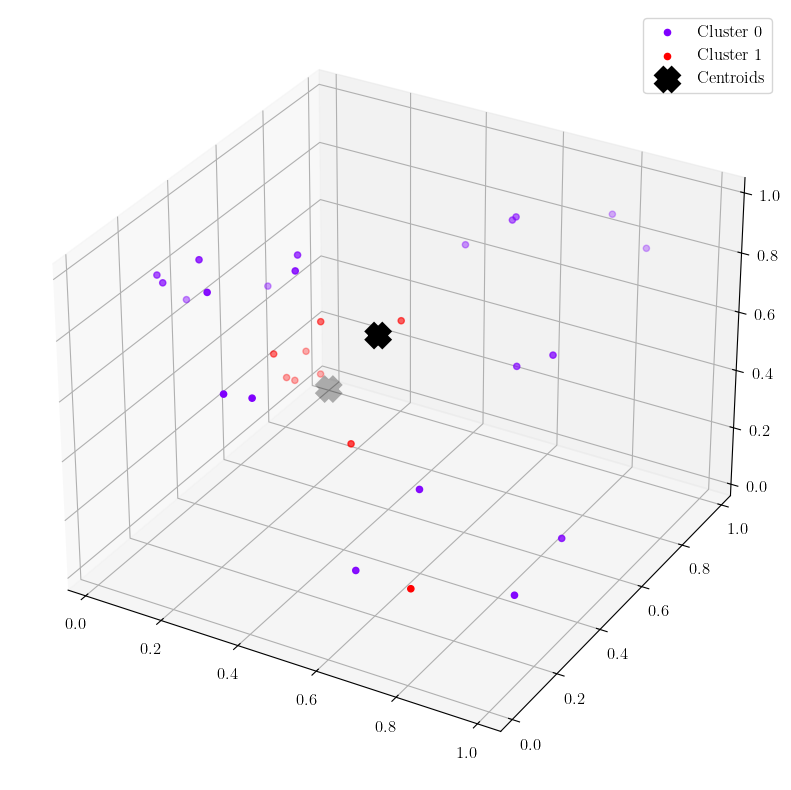

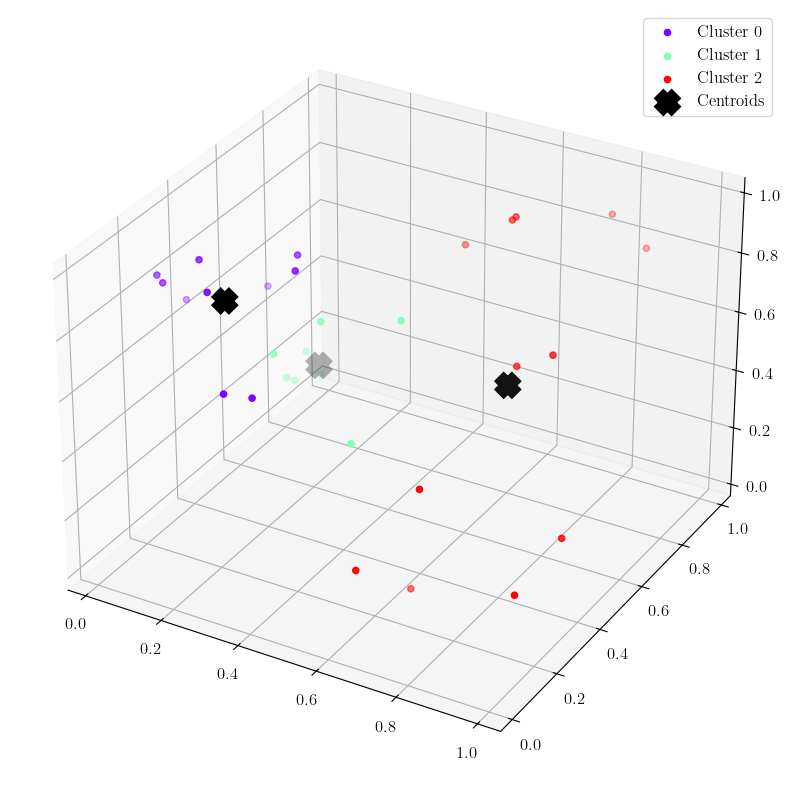

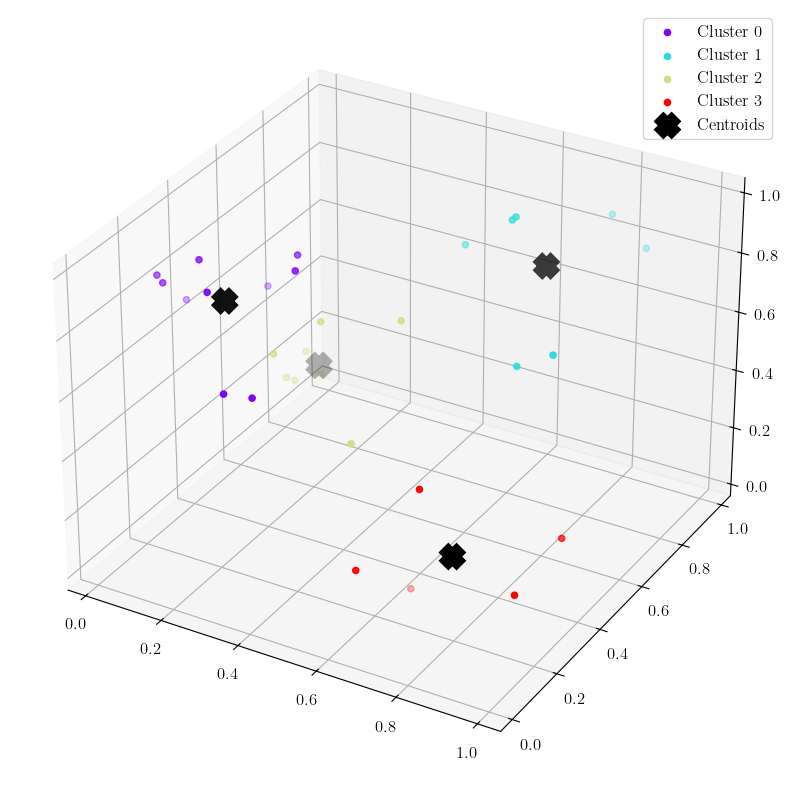

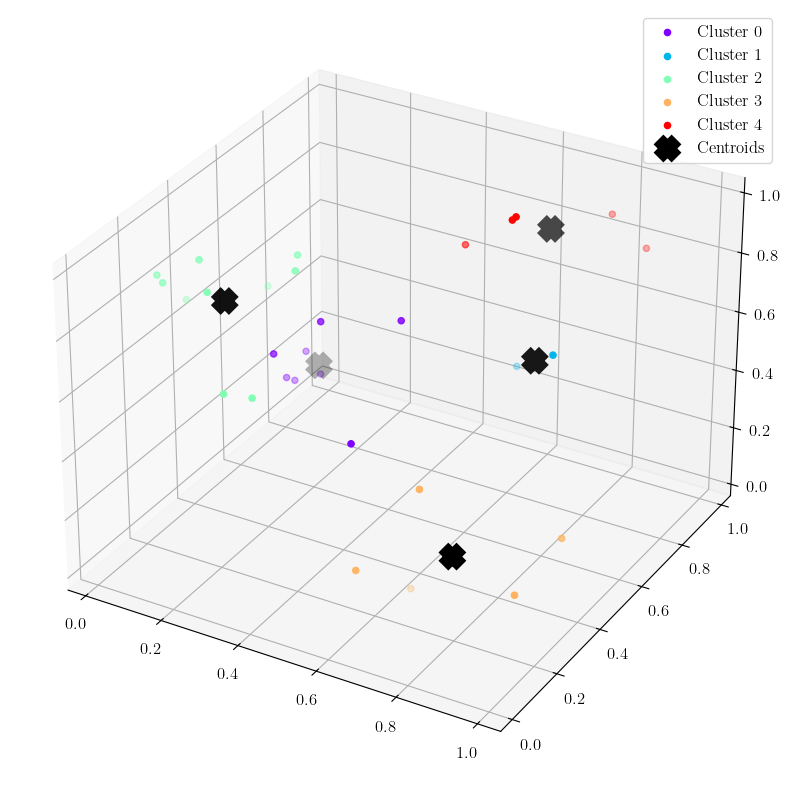

In [111]:
if np.array_equal(coor_weirdos_Li, np.array([])) == False:

    centroids_2, labels_2 = Operation.KMeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 2)
    centroids_3, labels_3 = Operation.KMeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 3)
    centroids_4, labels_4 = Operation.KMeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 4)
    centroids_5, labels_5 = Operation.KMeans.kmeans_cluster_atoms(coor_weirdos_Li, amount_clusters = 5)

    print(f"centroids: \n {centroids_2}")
    print(f"centroids: \n {centroids_3}")
    print(f"centroids: \n {centroids_4}")
    print(f"centroids: \n {centroids_5}")

    Operation.KMeans.create_POSCAR_atoms_centroids_appended(coor_weirdos_Li, centroids_2, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids2")
    Operation.KMeans.create_POSCAR_atoms_centroids_appended(coor_weirdos_Li, centroids_3, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids3")
    Operation.KMeans.create_POSCAR_atoms_centroids_appended(coor_weirdos_Li, centroids_4, direc_restructure_destination, lattice_constant, filename = "POSCAR_weirdos_centroids4")

    plot_distweirdos(file_loc_important_cols)

# visualization of mapped atom

In [112]:
df = Plot.Mapping.Labelling.plot_mapped_label_vs_dist_and_histogram(file_loc_important_cols, litype, category_data = "mapping", el = "Li")

In [113]:
# file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_weirdos_Li","sum_weirdos_48htype2_Li","dist_weirdos_atom"dist_weirdos_48htype2_atom72_Li","idx1_weirdos_Li","#weirdos_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
if activate_radius == 3:
    file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype1_48htype2_Li_closestduplicate","sum_weirdos_48htype1_48htype2_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
    file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","sum_weirdos_Li","sum_mapped_48htype1_48htype2_Li_closestduplicate","sum_weirdos_48htype1_48htype2_Li","sum_mapped_48htype2_Li_closestduplicate","#weirdos_Li","sum_mapped_48htypesmerged_Li","sum_sanitycheck_48htypesmerged_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","toten [eV]"]]
    
    sum_weirdos_Li = float(file_loc_important_cols_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}"

elif activate_radius == 2:
    if litype == 2:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 3:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 4:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 5:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 6:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 7:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 8:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]]   

    sum_weirdos_Li = float(file_loc_important_cols_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}"

elif activate_radius == 1:
    if litype == 2:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 3:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 4:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 5:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_24g_Li","atom_mapping_Li_w_dist_label","toten [eV]"]]
    elif litype == 6:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 7:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_24g_Li","toten [eV]"]] 
    elif litype == 8:
        file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
        file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","sum_mapped_Li_closestduplicate","#weirdos_Li","idx0_weirdos_Li","top3_sorted_idxweirdo_dist_Li","top3_sorted_idxweirdo_label_Li","#closest_48htype1_Li","#closest_48htype2_Li","#closest_48htype3_Li","#closest_48htype4_Li","#closest_48htype5_Li","#closest_48htype6_Li","#closest_48htype7_Li","#closest_48htype8_Li","#closest_24g_Li","toten [eV]"]]   

    sum_weirdos_Li = float(file_loc_important_cols_sorted_toten["#weirdos_Li"].sum())

    var_excel_file = f"map2type2_{sum_weirdos_Li}_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}"

In [114]:
df = Plot.Mapping.Labelling.plot_mapped_label_vs_dist_and_histogram(file_loc_important_cols, litype, category_data = "mapping", el = "Li")

df_48htype2 = df.loc[df['label'] == '48htype2']

fig = px.scatter(df_48htype2, 
                x = 'idx_nr', 
                y = 'dist',
                title = 'Distance of mapped 48htype2 vs its file index nr'
                )

fig.show(config={'scrollZoom': True})

# find radius that removes all weirdos in the first groups

## all weirdos

In [115]:
df = Plot.Mapping.Labelling.plot_mapped_label_vs_dist_and_histogram(file_loc_important_cols, litype, category_data = "weirdo", el = "Li")

fig = px.scatter(df, 
                x = 'idx_nr', 
                y = 'dist',
                # mode = "markers"
                color = 'label',
                title = 'Distance of weirdos vs its file index nr (0: lowest energy)',
                hover_data = ['dist', 'label', 'idx_nr', 'coor']
                )

fig.show(config={'scrollZoom': True}) 

# weirdos of 0:17

In [116]:
df = Plot.Mapping.Labelling.plot_mapped_label_vs_dist_and_histogram(file_loc_important_cols[:17], litype, category_data = "weirdo", el = "Li")

fig = px.scatter(df, 
                x = 'idx_nr', 
                y = 'dist',
                # mode = "markers"
                color = 'label',
                title = 'Distance of weirdos vs its file index nr'
                )

fig.show(config={'scrollZoom': True})

In [117]:
file_loc_important_cols_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}_sorted.xlsx', index=False)
file_loc_important_cols_not_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}.xlsx', index=False)

In [118]:
if activate_radius == 1:
    file_loc_important_cols.to_pickle(f'file_loc_important_cols_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}.pkl') 
elif activate_radius == 2:
    file_loc_important_cols.to_pickle(f'file_loc_important_cols_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}.pkl')
elif activate_radius == 3:
    file_loc_important_cols.to_pickle(f'file_loc_important_cols_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}.pkl')

In [119]:
file_loc_important_cols.columns

Index(['geometry', 'path', 'subdir_new_system', 'g+p', 'g+p+1', 'g+p-1',
       'perfect_system', 'p_s_mask', 'toten [eV]', 'subdir_positive_CONTCAR',
       'coor_structure_init_dict', 'flag_Li', 'coor_weirdos_Li',
       'sum_weirdos_Li', 'duplicate_closest24_w_data_Li',
       'coor_reducedreference_Li_closestduplicate',
       'sum_mapped_Li_closestduplicate', 'sum_sanitycheck_Li_closestduplicate',
       'atom_mapping_Li_closestduplicate',
       'atom_mapping_Li_w_dist_closestduplicate', 'idx0_weirdos_Li',
       '#weirdos_Li', 'idx_coor_weirdos_Li', 'idx_correcting_Li',
       'coor_reducedreference_sorted_Li', '#closest_24g_Li',
       '#closest_48htype1_Li', '#closest_48htype2_Li', '#closest_48htype3_Li',
       '#closest_48htype4_Li', 'top3_sorted_idxweirdo_dist_label_Li',
       'top3_sorted_idxweirdo_dist_Li', 'top3_sorted_idxweirdo_label_Li',
       'top1_sorted_idxweirdo_dist_label_Li', 'top1_sorted_idxweirdo_dist_Li',
       'top1_sorted_idxweirdo_label_Li', 'top1_sorted

In [ ]:
file_loc_important_cols['atom_mapping_Li_w_dist_label'][1]

In [ ]:
file_loc_important_cols_sorted_complete = file_loc_important_cols.sort_values("toten [eV]", ascending=True).reset_index()

In [ ]:
file_loc_important_cols_sorted_complete

In [ ]:
file_loc_important_cols_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][26]

In [ ]:
file_loc_important_cols_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][11]

In [ ]:
file_loc_important_cols_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][20]

In [ ]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=FutureWarning)

In [ ]:
dataframe = file_loc_important_cols_sorted_complete

col_idx_coor24li_tuple_cage_belongin_complete_id48htype2 = 'idx_coor24li_tuple_cage_belongin_complete_id48htype2'

col_idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = "idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    for idx in range(dataframe["geometry"].size):

        # idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = defaultdict(list)

        idx_coor24li_tuple_cage_belongin_complete_id48htype2 = dataframe[col_idx_coor24li_tuple_cage_belongin_complete_id48htype2][idx]

        # Filtered dictionary
        idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = {key: value for key, value in idx_coor24li_tuple_cage_belongin_complete_id48htype2.items() if value['type'] in ['weirdos', '48htype1']}

        # # Check if filtered dictionary is empty, if so, set it to {}
        # if not idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered:
        #     idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered = {}

        print(idx)
        print(idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered)

        dataframe.at[idx, col_idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered] = idx_coor24li_tuple_cage_belongin_complete_id48htype2_filtered

        # # Iterate through each key, value pair in the dictionary
        # for key, value in idx_coor24li_tuple_cage_belongin_complete_id48htype2.items():
        #     # Check if the 'type' is 'weirdos' or '48htype4'
        #     if value['type'] in ['weirdos', '48htype4']:
        #         # Print the key and value
        #         print(f"Key: {key}, Value: {value}")

In [ ]:
{key: value for key, value in file_loc_important_cols_sorted_complete['idx_coor24li_tuple_cage_belongin_complete_id48htype2'][42].items() if value['type'] in ['weirdos', '48htype1']}

In [ ]:
coor_48htype1_metainfo

In [ ]:
idx_cage_dict = {key: value['idx_cage'] for key, value in file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_closest'][0].items()}
print(idx_cage_dict)


In [ ]:
idx_cage_dict = {key: value['idx_cage'] for key, value in file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_closest'][8].items()}
print(idx_cage_dict)


In [ ]:
different_idx_cage = {
    key: value['idx_cage']
    for key, value in file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_closest'][8].items()
    if value['idx_cage'] != file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_closest'][0][key]['idx_cage']
}

print(different_idx_cage)


In [ ]:
Operation.Distance.mic_eucledian_distance([0.66882, 0.47147, 0.16882], [0.33118, 0.52853, 0.16882])

In [ ]:
Operation.Distance.mic_eucledian_distance([0.97111, 0.25000, 0.25000], [0.97147, 0.33118, 0.33118])

In [ ]:
Operation.Distance.mic_eucledian_distance([0.75000, 0.25000, 0.25000], [0.25000, 0.75000, 0.25000])

In [ ]:
Operation.Distance.mic_eucledian_distance([0.79503, 0.43060, 0.43057], [0.93057, 0.70497, 0.56940])

In [ ]:
Operation.Distance.mic_eucledian_distance([0.06943, 0.79503, 0.06940], [0.97111, 0.75000, 0.75000])

In [ ]:
file_loc_important_cols['idx_coor24li_tuple_cage_belongin_complete_closest'][0]

In [ ]:
xxxx - xx

# Optimize dx_dz of 48htype1, r_2 for files w/o weirdos

In [ ]:
df_wo_weirdos_selectedcol = file_loc_important_cols[['geometry','path','subdir_new_system', 'toten [eV]']].sort_values("toten [eV]", ascending=True)[0:17].reset_index().copy()

In [ ]:
df_wo_weirdos_selectedcol

In [ ]:
if activate_radius == 3:
    folder_name_destination_restructure_wo_weirdos = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{max_mapping_radius_48htype1_48htype2}_{file_perfect_poscar_48n24_wo_cif}_wo_weirdos/"
elif activate_radius == 2:
    folder_name_destination_restructure_wo_weirdos = f"/restructure_{max_mapping_radius}_{max_mapping_radius_48htype2}_{file_perfect_poscar_48n24_wo_cif}_wo_weirdos/"
elif activate_radius == 1:
    folder_name_destination_restructure_wo_weirdos = f"/restructure_{max_mapping_radius}_{file_perfect_poscar_48n24_wo_cif}_wo_weirdos/"
else:
    print("activate_radius is not correct")

direc_restructure_destination_wo_weirdos = direc+str(folder_name_destination_restructure_wo_weirdos)

In [ ]:
# just refreshing folder
Operation.File.check_folder_existance(direc_restructure_destination_wo_weirdos, empty_folder=True)

# # # # # # just copy file
# # # # # Operation.File.copy_rename_single_file(direc_restructure_destination_wo_weirdos, direc_perfect_poscar, file_perfect_poscar_24, prefix=None)
# # # # # Operation.File.copy_rename_single_file(direc_restructure_destination_wo_weirdos, direc_perfect_poscar, file_perfect_poscar_48n24, prefix=None)

# # # # # Operation.File.copy_rename_files(df_wo_weirdos_selectedcol, direc_restructure_destination_wo_weirdos, file_restructure, prefix=None, savedir = True)

In [ ]:
coor_ref_structure_48n24 = ReadStructure.Coor.get_coor_structure_init_dict(ref_structure_48n24)

PreProcessingCONTCAR.get_positive_lessthan1_poscarorcontcar(df_wo_weirdos_selectedcol, direc_restructure_destination_wo_weirdos, poscar_line_nr_start, poscar_line_nr_end, contcar_columns_type2, file_type = "CONTCAR", var_name_in = None, var_name_out = "positive", n_decimal=16)
ReadStructure.Coor.get_coor_structure_init_dict_wholedataframe(df_wo_weirdos_selectedcol, mapping = "False")

if activate_radius == 3:
    Mapping.get_flag_map_weirdos_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius)
    Mapping.get_flag_map_weirdos_48htype1_48htype2_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype1_48htype2)
    Mapping.get_flag_map_weirdos_48htypesmerged_level1_el(df_wo_weirdos_selectedcol, "Li")
    Mapping.get_flag_map_weirdos_48htype2_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    Mapping.get_flag_map_48htypesmerged_el(df_wo_weirdos_selectedcol, "Li", activate_radius)
elif activate_radius == 2:
    Mapping.get_flag_map_weirdos_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius)
    Mapping.get_flag_map_weirdos_48htype2_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius_48htype2, activate_radius)
    Mapping.get_flag_map_48htypesmerged_el(df_wo_weirdos_selectedcol, "Li", activate_radius)
elif activate_radius == 1:
    Mapping.get_flag_map_weirdos_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Li", max_mapping_radius)

# Mapping.get_flag_map_weirdos_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "P", max_mapping_radius)
# Mapping.get_flag_map_weirdos_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "S", max_mapping_radius)
# Mapping.get_flag_map_weirdos_el(df_wo_weirdos_selectedcol, coor_ref_structure_48n24, "Cl", max_mapping_radius)

In [ ]:
xxx - xxxx

In [ ]:
dataframe = file_loc_important_cols

col_top1_sorted_idxweirdo_dist_el = "top1_sorted_idxweirdo_dist_Li"
col_top1_sorted_idxweirdo_label_el = "top1_sorted_idxweirdo_label_Li"
col_top1_sorted_idxweirdo_coor_el = "top1_sorted_idxweirdo_coor_Li"
col_top1_sorted_idxweirdo_file_el = "top1_sorted_idxweirdo_file_Li"

val = 0.

dist_weirdos_el_appendend = []
y_appended = []
label_weirdos_el_appended = []
coor_weirdos_el_appended = []
file_weirdos_el_appended = []

for idx in range(dataframe["geometry"].size):
    dist_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_dist_el].values()
    label_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_label_el].values()
    coor_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_coor_el].values()
    file_weirdos_el = dataframe.at[idx, col_top1_sorted_idxweirdo_file_el].values()

    for single_dist in dist_weirdos_el:
        dist_weirdos_el_appendend.append(single_dist[0])
        y_appended.append(np.zeros_like(single_dist[0]) + val)

    for single_label in label_weirdos_el:
        label_weirdos_el_appended.append(single_label[0])

    for single_coor in coor_weirdos_el:
        coor_weirdos_el_appended.append(single_coor[0])
    
    for single_file in file_weirdos_el:
        file_weirdos_el_appended.append(single_file[0])

df = pd.DataFrame({'dist': dist_weirdos_el_appendend, 'label': label_weirdos_el_appended, 'y': y_appended, 'coor': coor_weirdos_el_appended, 'file': file_weirdos_el_appended})

# fig = px.scatter(df, x = 'dist', y = 'y', color='label', color_discrete_map={'48htype1': 'red', '48htype2': 'blue', '24g': 'green'})
fig = px.scatter(df, 
                 x = 'dist', 
                 y = 'y', 
                 color ='label', 
                 hover_data = ['dist', 'label', 'coor', 'file'])


fig.show(config={'scrollZoom': True})

In [ ]:
0.04718813922672343

In [ ]:
# from sklearn.cluster import MeanShift, estimate_bandwidth

# x = [1,1,5,6,1,5,10,22,23,23,50,51,51,52,100,112,130,500,512,600,12000,12230]

# X = np.array(list(zip(x,np.zeros(len(x)))), dtype='int')
# bandwidth = estimate_bandwidth(X, quantile=0.1)
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(X)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# for k in range(n_clusters_):
#     my_members = labels == k
#     print("cluster {0}: {1}".format(k, X[my_members, 0]))

In [ ]:
# DBSCAN
# source: https://stackoverflow.com/questions/11513484/1d-number-array-clustering

# points = [0.1, 0.31,  0.32, 0.45, 0.35, 0.40, 0.5 ]
points = dist_weirdos_el_appendend

clusters = []
# eps = 0.2
eps = 0.043
points_sorted = sorted(points)
curr_point = points_sorted[0]
curr_cluster = [curr_point]
for point in points_sorted[1:]:
    if point <= curr_point + eps:
        curr_cluster.append(point)
    else:
        clusters.append(curr_cluster)
        curr_cluster = [point]
    curr_point = point
clusters.append(curr_cluster)
print(clusters)

In [ ]:
for i in clusters:
    print(i)

In [ ]:
clusters[0][int(len(clusters[0])/2)]

In [ ]:
len(clusters[0])

In [ ]:
len(clusters)

## another idea: plot based on litype

In [ ]:
# from sklearn.datasets import make_swiss_roll

# X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
        # # source: https://plotly.com/python/v3/3d-point-clustering/
        # scatter = dict(
        #     mode = "markers",
        #     name = "y",
        #     type = "scatter3d",
        #     x = coordinates[0], y = coordinates[1], z = coordinates[2],
        #     # x = tuple(coordinates[0]), y = tuple(coordinates[1]), z = tuple(coordinates[2]),
        #     marker = dict( size=2, color="rgb(23, 190, 207)" )
        # )

        # clusters = dict(
        #     alphahull = 7,
        #     name = "y",
        #     opacity = 0.1,
        #     type = "mesh3d",
        #     x = coordinates[0], y = coordinates[1], z = coordinates[2]
        # )

        # layout = dict(
        #     title = '3d point clustering',
        #     scene = dict(
        #         xaxis = dict( zeroline=False ),
        #         yaxis = dict( zeroline=False ),
        #         zaxis = dict( zeroline=False ),
        #     )
        # )

        # fig = dict( data=[scatter, clusters], layout=layout )

        # # Use py.iplot() for IPython notebook
        # pyoff.iplot(fig, filename='3d point clustering')

        # scatter = go.Scatter3d(
        #     mode="markers",
        #     name="y",
        #     x=coordinates[0],
        #     y=coordinates[1],
        #     z=coordinates[2],
        #     marker=dict(size=2, color="rgb(23, 190, 207)")
        # )

        # clusters = go.Mesh3d(
        #     alphahull=7,
        #     name="y",
        #     opacity=0.1,
        #     x=coordinates[0],
        #     y=coordinates[1],
        #     z=coordinates[2]
        # )

        # layout = go.Layout(
        #     title='3d point clustering',
        #     scene=dict(
        #         xaxis=dict(zeroline=False),
        #         yaxis=dict(zeroline=False),
        #         zaxis=dict(zeroline=False),
        #     )
        # )

        # fig = go.Figure(data=[scatter, clusters], layout=layout)

        # # Use iplot() for offline plotting
        # # iplot(fig, filename='3d point clustering')
        # pyoff(fig, filename='3d point clustering')

In [ ]:
PreProcessingCONTCAR.get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated_positive_lessthan1")
Operation.Cartesian.get_fractional_to_cartesian_matrix(file_loc_important_cols, var_filename = "trf_w_linalg_orientated_positive_lessthan1", angle_in_degrees=True)
Operation.Cartesian.get_fractional_to_cartesian_coor(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated_positive_lessthan1")

In [ ]:
max_neighbors_radius = 5
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Li", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "P", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "S", var_filename = "trf_w_linalg_orientated_positive_lessthan1")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Cl", var_filename = "trf_w_linalg_orientated_positive_lessthan1")

In [ ]:
# file_loc_important_cols["distance_cartesian_trf_w_linalg_orientated_positive_S"][45]

In [ ]:
# my_dict = file_loc_important_cols["distance_cartesian_trf_w_linalg_orientated_positive_Li"][45]

# max_length = max(len(lst) for lst in my_dict.values())

# # Fill in missing values with None to make all lists the same length
# for key in my_dict:
#     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # Create a DataFrame from the modified dictionary
# df_my_dict = pd.DataFrame(my_dict)

# df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# df_my_dict = df_my_dict.sort_index(axis=1)
# df_my_dict = df_my_dict.transpose()
# # Save the DataFrame to an Excel file without the index
# df_my_dict.to_excel('neighbors_Li_trf_w_linalg_orientated_positive_45.xlsx', index=True)

In [ ]:
PreProcessingCONTCAR.get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "CONTCAR")
Operation.Cartesian.get_fractional_to_cartesian_matrix(file_loc_important_cols, var_filename = "CONTCAR", angle_in_degrees=True)
Operation.Cartesian.get_fractional_to_cartesian_coor(file_loc_important_cols, direc_restructure_destination, var_filename = "CONTCAR")

In [ ]:
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Li", var_filename = "CONTCAR")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "P", var_filename = "CONTCAR")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "S", var_filename = "CONTCAR")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Cl", var_filename = "CONTCAR")

In [ ]:
# # # file_loc_important_cols["distance_cartesian_CONTCAR_S"][45]

In [ ]:
# # # my_dict = file_loc_important_cols["distance_cartesian_CONTCAR_Li"][45]

# # # max_length = max(len(lst) for lst in my_dict.values())

# # # # Fill in missing values with None to make all lists the same length
# # # for key in my_dict:
# # #     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # # # Create a DataFrame from the modified dictionary
# # # df_my_dict = pd.DataFrame(my_dict)

# # # df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# # # df_my_dict = df_my_dict.sort_index(axis=1)
# # # df_my_dict = df_my_dict.transpose()
# # # # Save the DataFrame to an Excel file without the index
# # # df_my_dict.to_excel(f'neighbors_Li_CONTCAR_45_{max_mapping_radius}.xlsx', index=True)

In [ ]:
PreProcessingCONTCAR.get_latticeconstant_structure_dict_iterated(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated")
Operation.Cartesian.get_fractional_to_cartesian_matrix(file_loc_important_cols, var_filename = "trf_w_linalg_orientated", angle_in_degrees=True)
Operation.Cartesian.get_fractional_to_cartesian_coor(file_loc_important_cols, direc_restructure_destination, var_filename = "trf_w_linalg_orientated")

In [ ]:
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Li", var_filename = "trf_w_linalg_orientated")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "P", var_filename = "trf_w_linalg_orientated")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "S", var_filename = "trf_w_linalg_orientated")
Operation.Cartesian.get_closest_neighbors_el_cartesian_coor(file_loc_important_cols, max_neighbors_radius, el = "Cl", var_filename = "trf_w_linalg_orientated")

In [ ]:
# # # my_dict = file_loc_important_cols["distance_cartesian_trf_w_linalg_orientated_Li"][45]

# # # max_length = max(len(lst) for lst in my_dict.values())

# # # # Fill in missing values with None to make all lists the same length
# # # for key in my_dict:
# # #     my_dict[key] += [None] * (max_length - len(my_dict[key]))

# # # # Create a DataFrame from the modified dictionary
# # # df_my_dict = pd.DataFrame(my_dict)

# # # df_my_dict.columns = ['_'.join(map(str, col)) for col in df_my_dict.columns]

# # # df_my_dict = df_my_dict.sort_index(axis=1)
# # # df_my_dict = df_my_dict.transpose()
# # # # Save the DataFrame to an Excel file without the index
# # # df_my_dict.to_excel(f'neighbors_Li_trf_w_linalg_orientated_45_{max_mapping_radius}.xlsx', index=True)

In [ ]:
# file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","dist_weirdos_atom72_Li","idx1_weirdos_Li","#weirdos_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
file_loc_important_cols_sorted_toten = file_loc_important_cols[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","idx0_weirdos_Li","sum_weirdos_Li","sum_mapped_Li_new","sum_sanitycheck_Li_new","duplicate_closest24_w_data_Li","toten [eV]"]].sort_values("toten [eV]", ascending=True)
file_loc_important_cols_not_sorted_toten = file_loc_important_cols[["geometry","path","coor_weirdos_Li","dist_weirdos_Li","idx0_weirdos_Li","sum_weirdos_Li","sum_mapped_Li_new","sum_sanitycheck_Li_new","duplicate_closest24_w_data_Li","toten [eV]"]]

file_loc_important_cols_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}_sorted.xlsx', index=False)
file_loc_important_cols_not_sorted_toten.to_excel(f'04_important_outputs_{var_excel_file}.xlsx', index=False)

In [ ]:
file_loc_important_cols['scaling'][48]

In [ ]:
file_loc_important_cols['translation'][48]

In [ ]:
lattice_constants_1_0 = [[10.0222501477270232, -0.0006786050655888, -0.0018947275007341], [-0.0006784775666570, 10.0236290992971000, 0.0006784775666570], [-0.0018947275007341, 0.0006786050655888, 10.0222501477270232]]

In [ ]:
np.dot(lattice_constants_1_0, file_loc_important_cols['scaling'][48].T)

In [ ]:
new_lattice_constant_1_0 = np.round(np.dot(lattice_constants_1_0, file_loc_important_cols['scaling'][48].T) + file_loc_important_cols['translation'][48], decimals=16)

In [ ]:
np.savetxt('new_constants_trial', new_lattice_constant_1_0)

In [ ]:
-0.11331824 + 1.89472750e-03

In [ ]:
1.00236291e+01 + 0.2500525

In [ ]:
-6.78477567e-04 + 0.38668173

In [ ]:
new_lattice_constant_1_0_precision = np.round(new_lattice_constant_1_0, decimals=16)

In [ ]:
new_lattice_constant_1_0_precision

In [ ]:
direc_restructure_destination

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_pymatgen.cif').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_trf_w_lib.cif').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_trf_w_linalg.cif').lattice

In [ ]:
new_lattice_constant_1_0_nottransposed = np.round(np.dot(lattice_constants_1_0, file_loc_important_cols['scaling'][48]) + file_loc_important_cols['translation'][48], decimals=16)

In [ ]:
np.savetxt('new_constants_trial_not_transposed', new_lattice_constant_1_0_nottransposed)

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_edit').lattice

In [ ]:
Structure.from_file('/home/azka/01_Masterthesis/01_Precondition/01_En_calc_13thiter_analysis/restructure_0.09_selected/1_0_CONTCAR_edit_not_transposed').lattice